# 1. Data Cleaning and Feature Engineering

In [89]:
import pandas as pd
import matplotlib.pyplot as plt
import re
%matplotlib inline
from pylab import rcParams
import numpy as np
rcParams['figure.figsize'] = 12, 10

In [28]:
# read in data
intakes = pd.read_csv("AnimalIntakes_2011-2019.csv")
outcomes = pd.read_csv("AnimalOutcomes_2011-2019.csv")

In [29]:
# external data found from research
dogbreedgroups = pd.read_csv("dogbreedgroups.csv")
breeddata = pd.read_csv("breed_data.csv")

In [30]:
intakes = intakes.fillna("")
outcomes = outcomes.fillna("")

# create datetime objects
intakes['Intake Date/Time'] = pd.to_datetime(intakes['Intake Date/Time'])
outcomes['Intake Date'] = pd.to_datetime(outcomes['Intake Date'])
outcomes['Outcome Date'] = pd.to_datetime(outcomes['Outcome Date'])

outcomes['Date'] = outcomes['Intake Date'].dt.date
intakes['DateIntakes'] = intakes['Intake Date/Time'].dt.date

# filter outcomes dataset
outcomes_subsetcols = ['Animal ID', 'Date', 'Distinguishing Markings', 'Date Of Birth', 'Age in Months Intake', 'Intake Type', 'Outcome Date','Outcome Type', 'Outcome Subtype','Reason']
outcomes = outcomes.filter(items=outcomes_subsetcols)


In [31]:
# join intakes data and outcomes data
full_dat = pd.merge(left=outcomes,right=intakes, how='left', left_on=['Animal ID','Date'], right_on=['Animal ID','DateIntakes'])
full_dat.dropna(subset=['DateIntakes'], inplace=True)

In [32]:
# drop columns that have too many missing values or are irrelevant to analysis
cols_to_drop = ['Distinguishing Markings', 'Date Of Birth', 'ARN', 'Danger', 'Danger Reason', 'Pet ID', 
                'Pet ID Type','Site Name', 'Injury Type', 'Cause','Age in Months Intake', 'Age',
               'Source', 'Intake Reason', 'Reason', 'Length Owned', 'Unit', 'Agency Name', 'Asilomar Status']

full_dat = full_dat.drop(columns=cols_to_drop)

In [33]:
# create features

# is the animal a mixed breed or not
def is_mix(row):
    if "Mix" in row['Secondary Breed']:
        val = 1
    else:
        val = 0
    return val

# is the animal's primary color black or not
def is_black(row):
    if row['Primary Colour'] != "Black":
        val = 1
    else:
        val = 0
    return val

# is the animal more than one color
def is_multicolor(row):
    if row['Secondary Colour'] != "":
        val = 1
    else:
        val = 0
    return val

# clean names for consistency, remove symbols, etc.
def clean_names(row):
    if row['Animal Name'].isdigit():
        val = ""
    elif '"' in row['Animal Name']:
        val = row['Animal Name'].replace('"','')
    elif "/" in row['Animal Name']:
        val = row['Animal Name'].split("/")[1]
    elif "male" in row['Animal Name'] or "MALE" in row['Animal Name'] or "FEMALE" in row['Animal Name']:
        val = ""
    elif "(" in row['Animal Name'] and ")" in row['Animal Name']:
        val = re.findall('\(([^)]+)', row['Animal Name'])[0]
    elif row['Animal Name'] == "TRUE":
        val = ""
    elif re.findall("\d", row['Animal Name']):
        val = re.sub(r"\d", "", row['Animal Name'])
    else:
        val = row['Animal Name']
        
    return val.upper().strip()

# does the animal have a name or not
def has_name(row):
    if row['Animal Name'] != "":
        val = 1
    else:
        val = 0
    return val

# name ends in the sound "ee" - feature was not used
def ends_with_ee(row):
    if row['clean_name'].endswith(tuple(["IE", "I", "Y", "EY", "EE"])):
        val = 1
    else:
        val = 0 
    return val

# keep the zip codes
def clean_jurisdiction(row):
    if len(row['Jurisdiction']) > 0:
        val = row['Jurisdiction'][-5:]
    else:
        val = ""
    return val

# create target variable for machine learning
def outcome_target(row):
    if row['Outcome Type'] == "Adoption" or row['Outcome Type'] == "Return to Owner/Guardian":
        val = "Success"
    elif row['Outcome Type'] == "Euthanasia":
        val = "Euthanasia"
    else:
        val = "DROP"
    return val

# is the primary breed a "top" dog breed
def top_dog(row):
    
    topdogs = ['Retriever, Labrador',
     'Terrier, American Pit Bull',
     'Terrier, Pit Bull',
     'Beagle',
     'Chihuahua, Short Coat',
     'German Shepherd',
     'Terrier, Jack Russell',
     'Terrier',
     'Shih Tzu',
     'Terrier, Yorkshire',
     'Boxer',
     'Shepherd',
     'Hound',
     'Siberian Husky',
     'Rottweiler',
     'Pomeranian',
     'Retriever, Golden',
     'Pug',
     'Border Collie',
     'Poodle, Miniature']

    if row['Primary Breed'] in topdogs:
        val = 1
    else:
        val = 0
    return val

# clean pit bull name for consistency
full_dat['Primary Breed'].replace(
    to_replace=['Terrier, American Pit Bull'],
    value='Terrier, Pit Bull',
    inplace=True)

# apply functions to create features
full_dat['clean_name'] = full_dat.apply(clean_names, axis=1)
full_dat['is_top_dog'] = full_dat.apply(top_dog, axis=1)

full_dat['is_mix'] = full_dat.apply(is_mix, axis=1)
full_dat['is_black'] = full_dat.apply(is_black, axis=1)
full_dat['is_multicolor'] = full_dat.apply(is_multicolor, axis=1)
full_dat['has_name'] = full_dat.apply(has_name, axis=1)
full_dat['ends_with_ee'] = full_dat.apply(ends_with_ee, axis=1)
full_dat['clean_jurisdiction'] = full_dat.apply(clean_jurisdiction, axis=1)
full_dat['outcome_target'] = full_dat.apply(outcome_target, axis=1)

full_dat['intake_dayofweek'] = full_dat['Intake Date/Time'].dt.day_name()
full_dat['intake_month'] = full_dat['Intake Date/Time'].dt.month_name()
full_dat['intake_hour'] = full_dat['Intake Date/Time'].dt.hour
full_dat['intake_year'] = full_dat['Intake Date/Time'].dt.year

full_dat['outcome_dayofweek'] = full_dat['Outcome Date'].dt.day_name()
full_dat['outcome_month'] = full_dat['Outcome Date'].dt.month_name()
full_dat['outcome_hour'] = full_dat['Outcome Date'].dt.hour
full_dat['outcome_year'] = full_dat['Outcome Date'].dt.year

full_dat['time_in_shelter'] = full_dat['Outcome Date'] - full_dat['Intake Date/Time']

In [34]:
# create dog breed group feature
full_dat = pd.merge(left=full_dat,right=dogbreedgroups, how='left', left_on=['Primary Breed'], right_on=['Breed'])
full_dat = full_dat.drop(columns="Breed")

In [35]:
# create breed specific features 
full_dat = pd.merge(left=full_dat,right=breeddata, how='left', left_on=['Primary Breed'], right_on=['Breed'])
full_dat = full_dat.drop(columns="Breed")

In [36]:
full_dat.columns

Index(['Animal ID', 'Date', 'Intake Type', 'Outcome Date', 'Outcome Type',
       'Outcome Subtype', 'Animal Name', 'Species', 'Primary Breed',
       'Secondary Breed', 'Gender', 'Altered', 'Primary Colour',
       'Secondary Colour', 'Third Colour', 'Colour Pattern',
       'Second Colour Pattern', 'Size', 'Pre Altered', 'Spayed Neutered',
       'Intake Date/Time', 'Operation Type', 'Operation Sub Type',
       'Jurisdiction', 'Condition', 'Age Group', 'DOA', 'Location',
       'Sub Location', 'DateIntakes', 'clean_name', 'is_top_dog', 'is_mix',
       'is_black', 'is_multicolor', 'has_name', 'ends_with_ee',
       'clean_jurisdiction', 'outcome_target', 'intake_dayofweek',
       'intake_month', 'intake_hour', 'intake_year', 'outcome_dayofweek',
       'outcome_month', 'outcome_hour', 'outcome_year', 'time_in_shelter',
       'Group', 'Coat', 'Energy', 'Lifespan', 'Shedding'],
      dtype='object')

# 2. EDA

In [58]:
plt.style.use('seaborn')

### Animals taken in per year by species

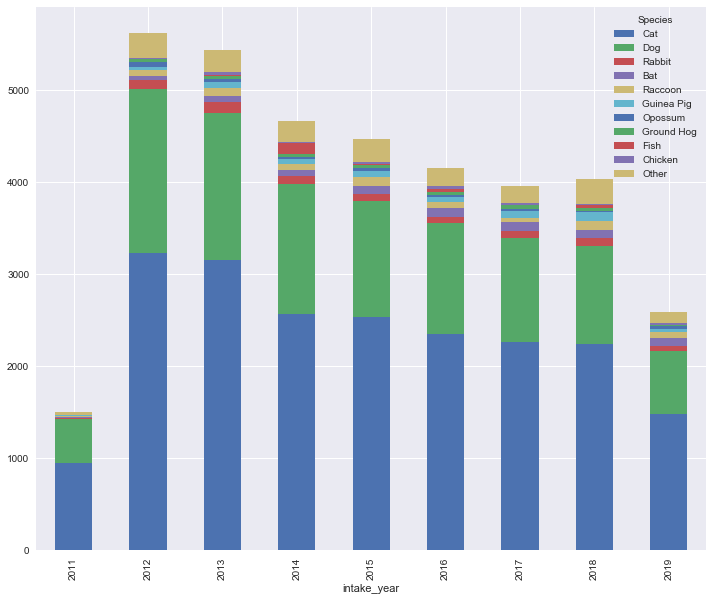

In [55]:
species_count = full_dat.groupby('intake_year')['Species'].value_counts().unstack().fillna(0)
# pull out top species
keep = ['Cat', 'Dog', 'Rabbit', 'Bat', 'Raccoon', 'Guinea Pig', 'Opossum', 'Ground Hog', 'Fish', 'Chicken']

other_columns = species_count.columns[~species_count.columns.isin(keep)]
species_count['Other'] = species_count[other_columns].sum(axis=1)

species_count = species_count[['Cat', 'Dog', 'Rabbit', 'Bat', 'Raccoon', 'Guinea Pig', 'Opossum', 'Ground Hog', 'Fish', 'Chicken', 'Other']]
# 2011 and 2019 are partial years but overall the trend is decreasing
species_count.plot.bar(stacked=True,figsize=(12,10));


### Top Dog Breeds

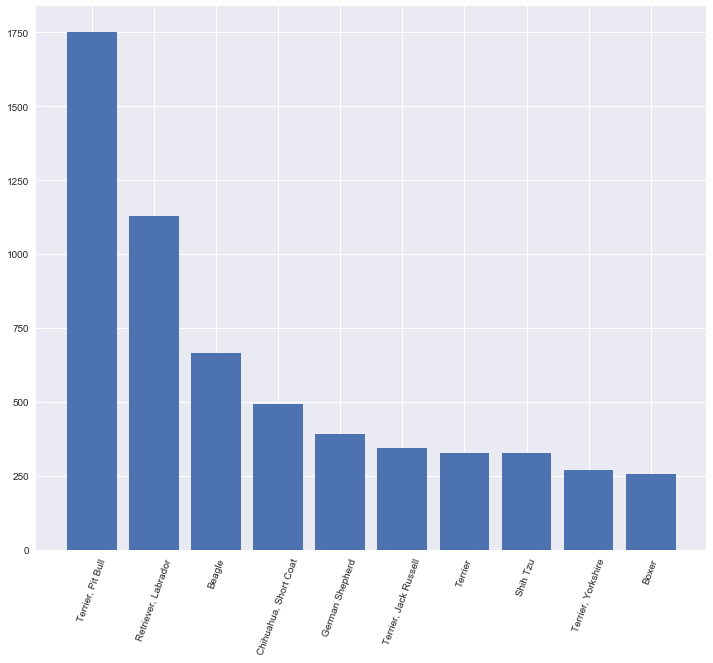

In [62]:
# top 10 dog breeds
top10dogs = pd.DataFrame(full_dat[full_dat['Species'] == 'Dog']['Primary Breed'].value_counts()[:10])

plt.bar(top10dogs.index, top10dogs['Primary Breed']);
plt.xticks(rotation=70);

# pitbulls and labs are the most popular

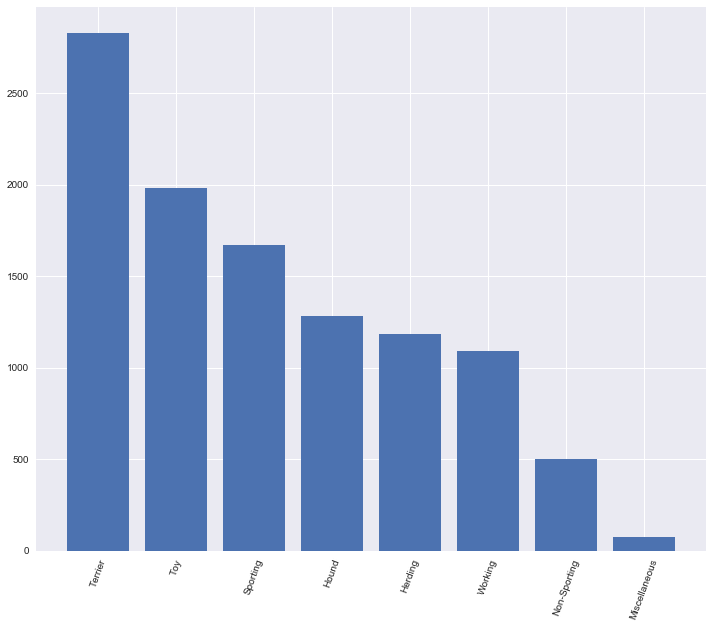

In [63]:
# dog groups
topgroups = pd.DataFrame(full_dat[full_dat['Species'] == 'Dog']['Group'].value_counts())

plt.bar(topgroups.index, topgroups['Group']);
plt.xticks(rotation=70);

### Top Cat Breeds

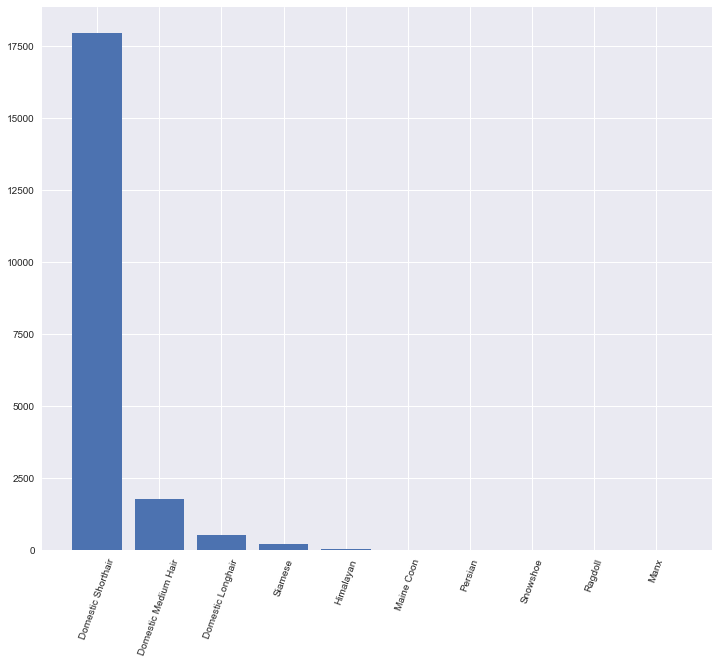

In [66]:
# top 10 cat breeds
top10cats = pd.DataFrame(full_dat[full_dat['Species'] == 'Cat']['Primary Breed'].value_counts()[:10])

plt.bar(top10cats.index, top10cats['Primary Breed']);
plt.xticks(rotation=70);

# they are almost always labeled domestic shorthair

### Dog Mix

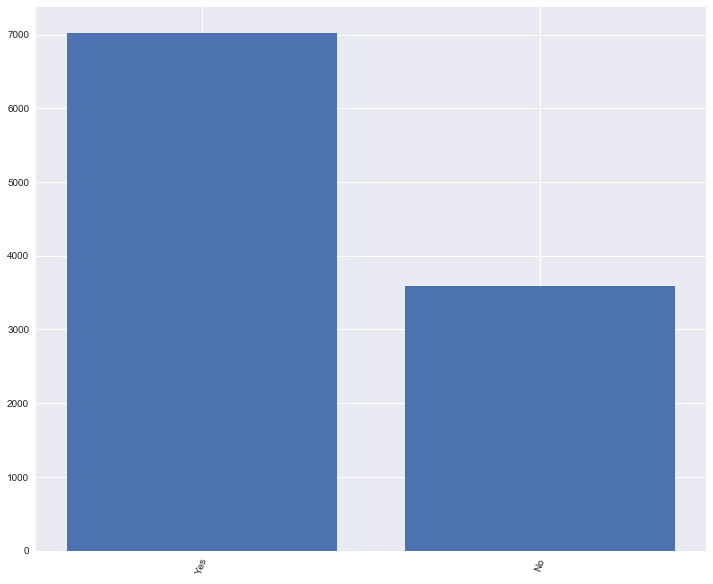

In [128]:
# is mix 
mix_counts = pd.DataFrame(full_dat[full_dat['Species'] == 'Dog']['is_mix'].value_counts())
mix_counts = mix_counts.rename(index={0: 'No'})
mix_counts = mix_counts.rename(index={1: 'Yes'})

plt.bar(mix_counts.index, mix_counts['is_mix']);
plt.xticks(rotation=70);

# majority are mixed breeds

### Cat Mix

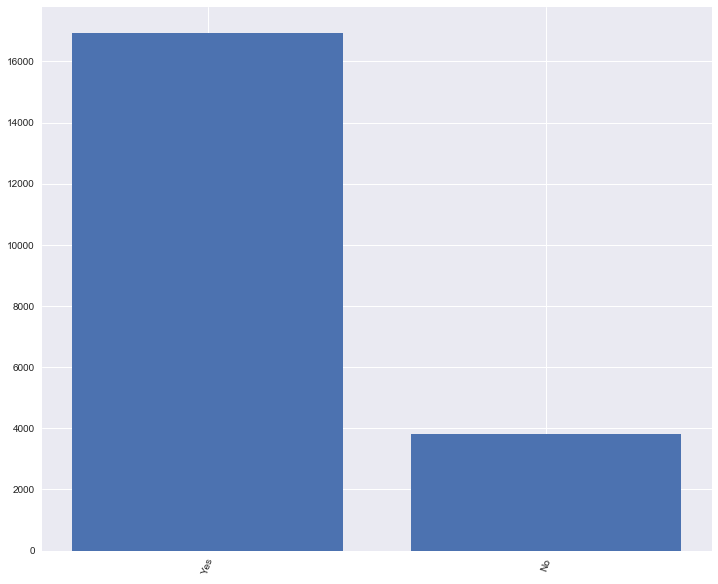

In [65]:
# is mix
mix_counts = pd.DataFrame(full_dat[full_dat['Species'] == 'Cat']['is_mix'].value_counts())
mix_counts = mix_counts.rename(index={0: 'No'})
mix_counts = mix_counts.rename(index={1: 'Yes'})

plt.bar(mix_counts.index, mix_counts['is_mix']);
plt.xticks(rotation=70);

# majority are mixed breeds

### Looking at Gender

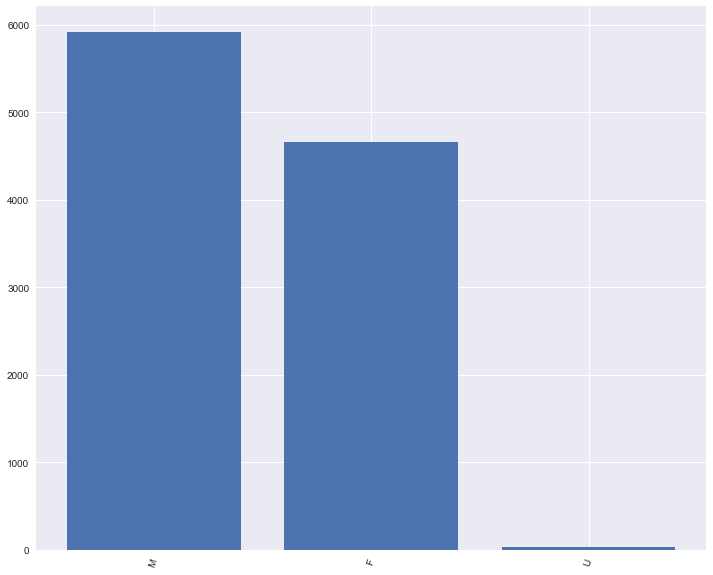

In [69]:
# dogs
dogs_gender = pd.DataFrame(full_dat[full_dat['Species'] == 'Dog']['Gender'].value_counts())

plt.bar(dogs_gender.index, dogs_gender['Gender']);
plt.xticks(rotation=70);

# more male than female

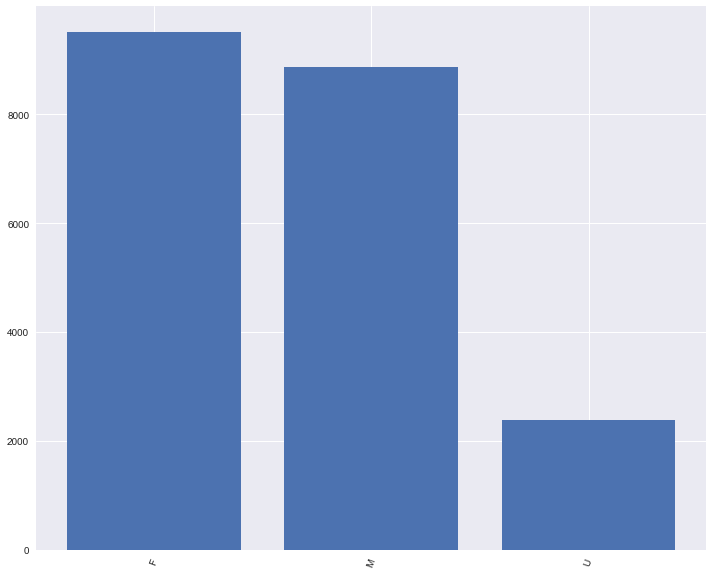

In [70]:
# cats
cats_gender = pd.DataFrame(full_dat[full_dat['Species'] == 'Cat']['Gender'].value_counts())

plt.bar(cats_gender.index, cats_gender['Gender']);
plt.xticks(rotation=70);

# more female than male

### Age Group

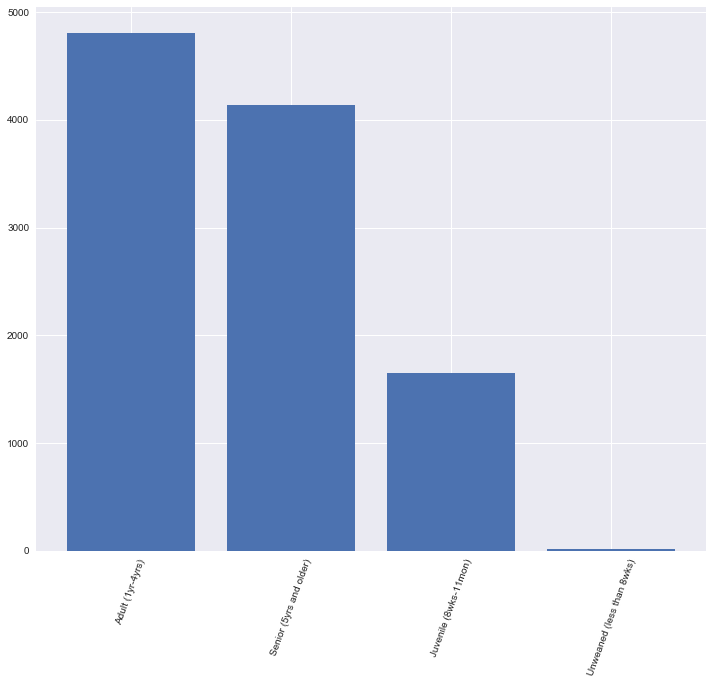

In [71]:
# dogs
dogs_age = pd.DataFrame(full_dat[full_dat['Species'] == 'Dog']['Age Group'].value_counts())

plt.bar(dogs_age.index, dogs_age['Age Group']);
plt.xticks(rotation=70);

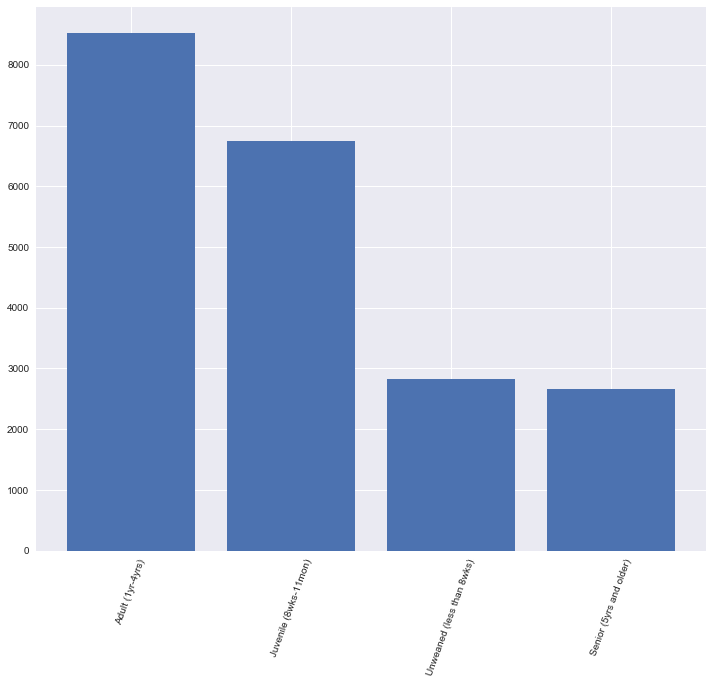

In [72]:
# cats
cats_age = pd.DataFrame(full_dat[full_dat['Species'] == 'Cat']['Age Group'].value_counts())

plt.bar(cats_age.index, cats_age['Age Group']);
plt.xticks(rotation=70);

### Size

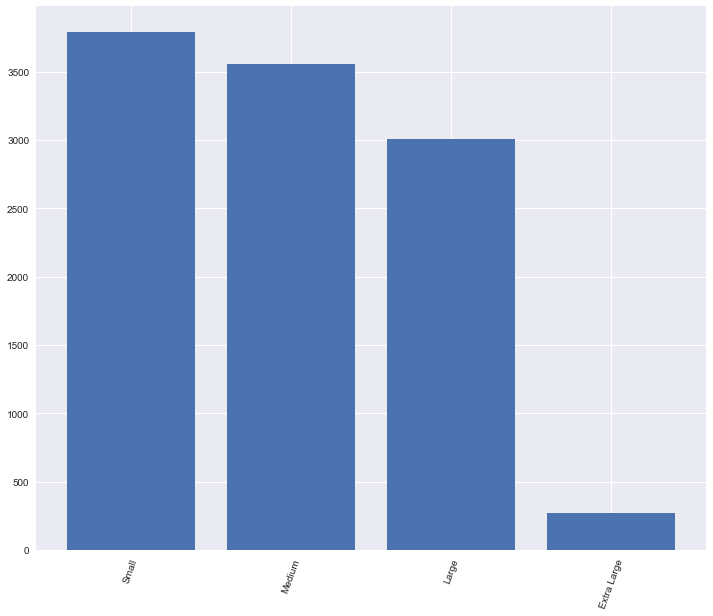

In [73]:
# dogs
dogs_size = pd.DataFrame(full_dat[full_dat['Species'] == 'Dog']['Size'].value_counts())

plt.bar(dogs_size.index, dogs_size['Size']);
plt.xticks(rotation=70);

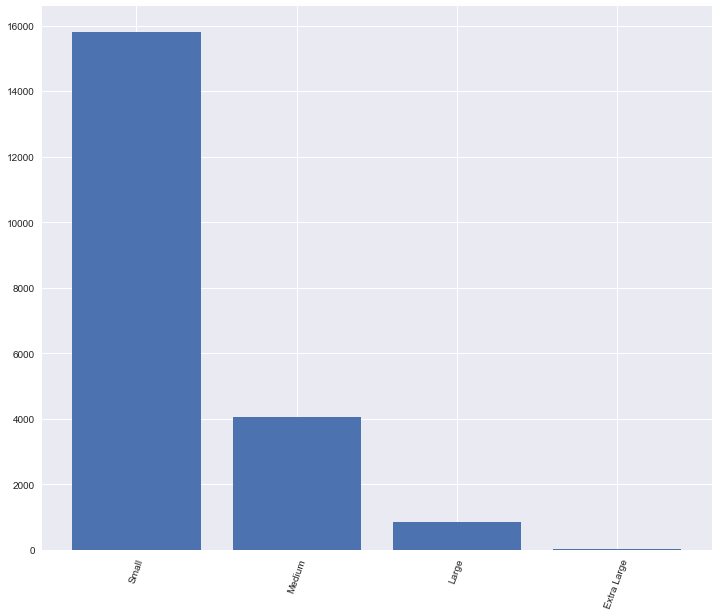

In [74]:
# cats
cats_size = pd.DataFrame(full_dat[full_dat['Species'] == 'Cat']['Size'].value_counts())

plt.bar(cats_size.index, cats_size['Size']);
plt.xticks(rotation=70);

### Spayed/Neutered

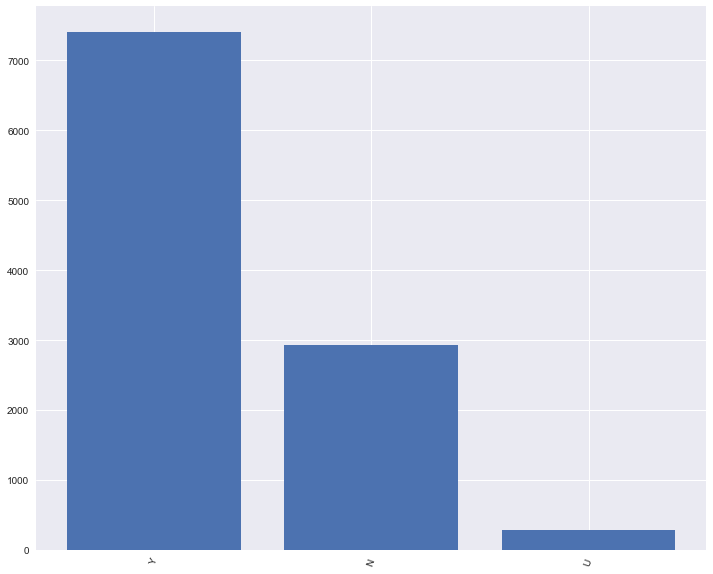

In [75]:
# dogs
dogs_SN = pd.DataFrame(full_dat[full_dat['Species'] == 'Dog']['Spayed Neutered'].value_counts())

plt.bar(dogs_SN.index, dogs_SN['Spayed Neutered']);
plt.xticks(rotation=70);

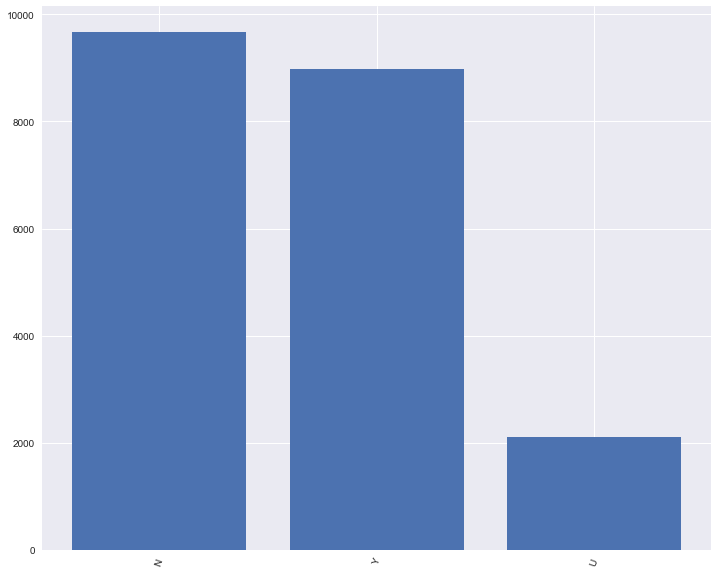

In [76]:
# cats
cats_SN = pd.DataFrame(full_dat[full_dat['Species'] == 'Cat']['Spayed Neutered'].value_counts())

plt.bar(cats_SN.index, cats_SN['Spayed Neutered']);
plt.xticks(rotation=70);

### Pre Altered

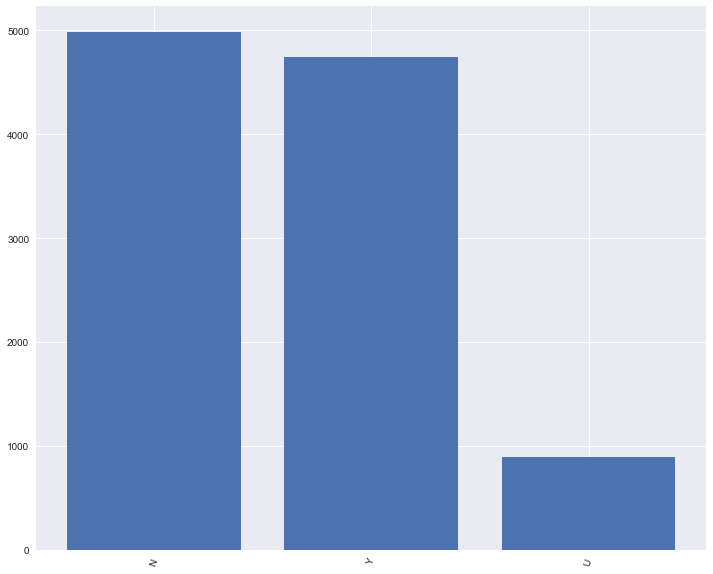

In [77]:
# dogs
dogs_altered = pd.DataFrame(full_dat[full_dat['Species'] == 'Dog']['Pre Altered'].value_counts())

plt.bar(dogs_altered.index, dogs_altered['Pre Altered']);
plt.xticks(rotation=70);

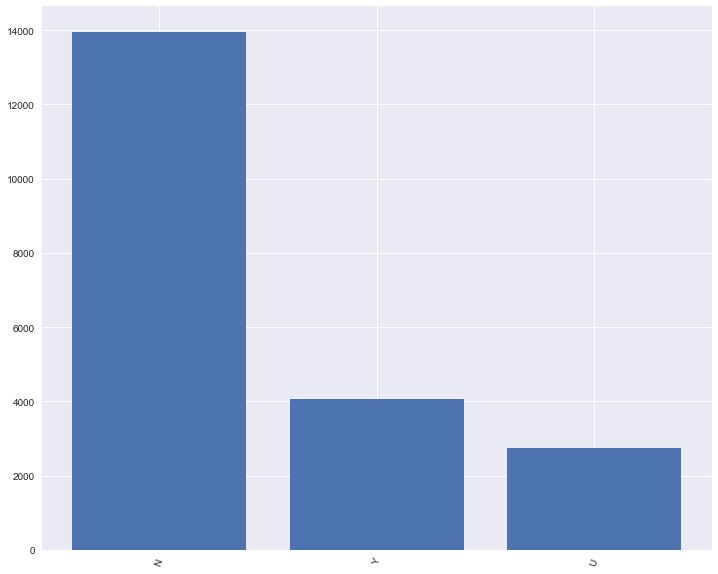

In [78]:
# cats
cats_altered = pd.DataFrame(full_dat[full_dat['Species'] == 'Cat']['Pre Altered'].value_counts())

plt.bar(cats_altered.index, cats_altered['Pre Altered']);
plt.xticks(rotation=70);

### Top Colors

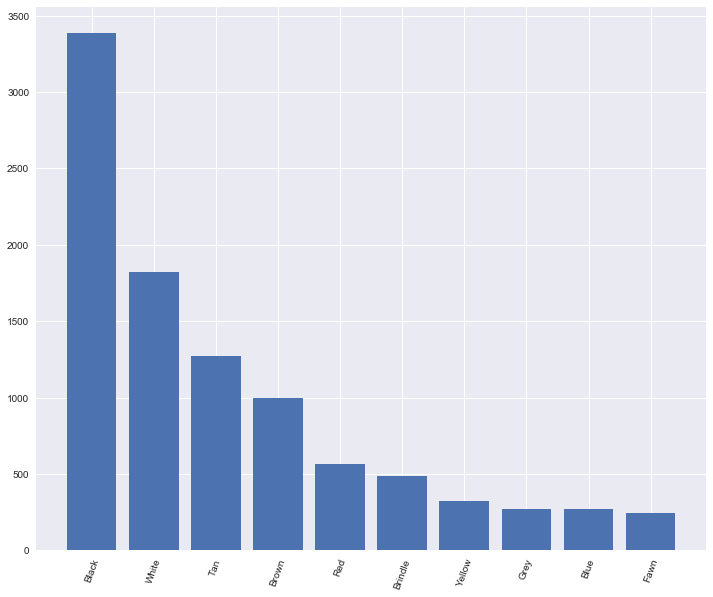

In [79]:
# dog colors
topdogcolors = pd.DataFrame(full_dat[full_dat['Species'] == 'Dog']['Primary Colour'].value_counts()[:10])

plt.bar(topdogcolors.index, topdogcolors['Primary Colour']);
plt.xticks(rotation=70);

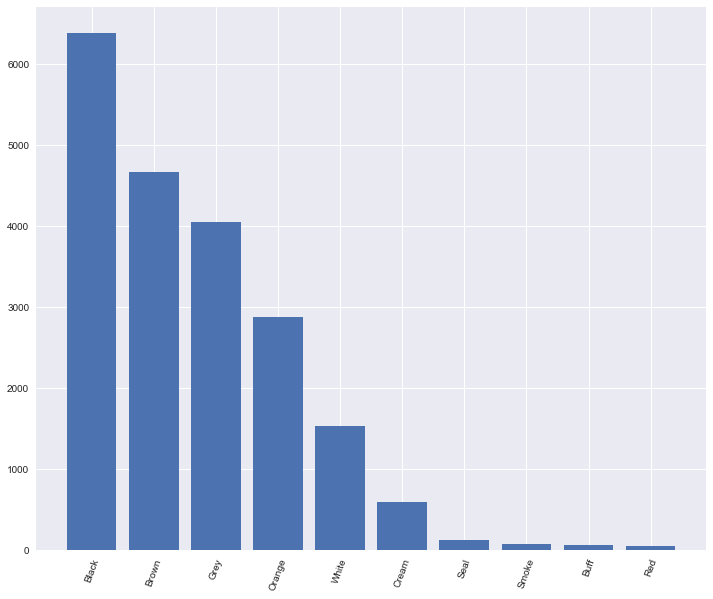

In [80]:
# cat colors
topcatcolors = pd.DataFrame(full_dat[full_dat['Species'] == 'Cat']['Primary Colour'].value_counts()[:10])

plt.bar(topcatcolors.index, topcatcolors['Primary Colour']);
plt.xticks(rotation=70);

### Analyzing Names

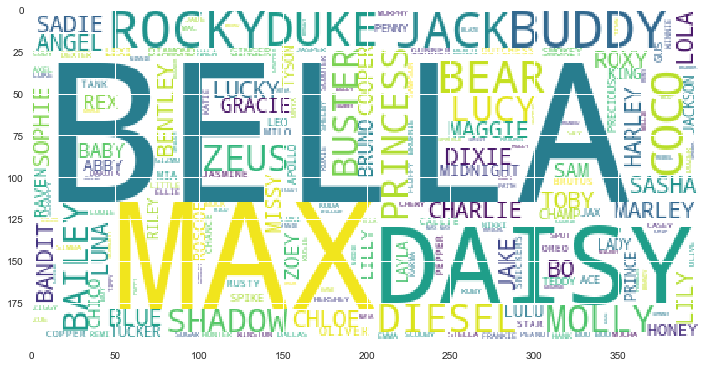

In [81]:
from wordcloud import WordCloud

# dog names
name_string=(" ").join(list(full_dat[full_dat['Species'] == 'Dog']['Animal Name']))
wordcloud = WordCloud(background_color="white").generate(name_string)
plt.imshow(wordcloud);

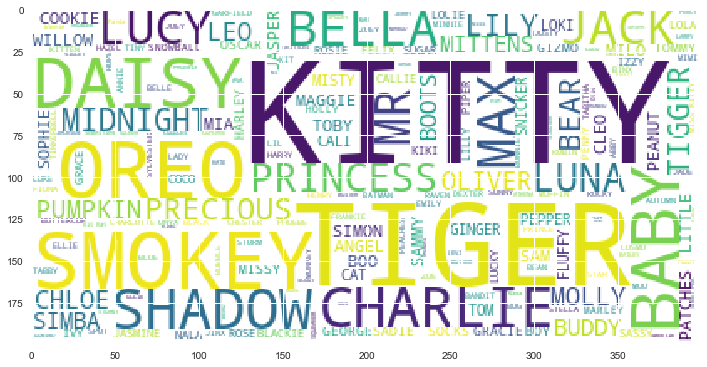

In [83]:
# cat names
name_string=(" ").join(list(full_dat[full_dat['Species'] == 'Cat']['Animal Name']))
wordcloud = WordCloud(background_color="white").generate(name_string)
plt.imshow(wordcloud);

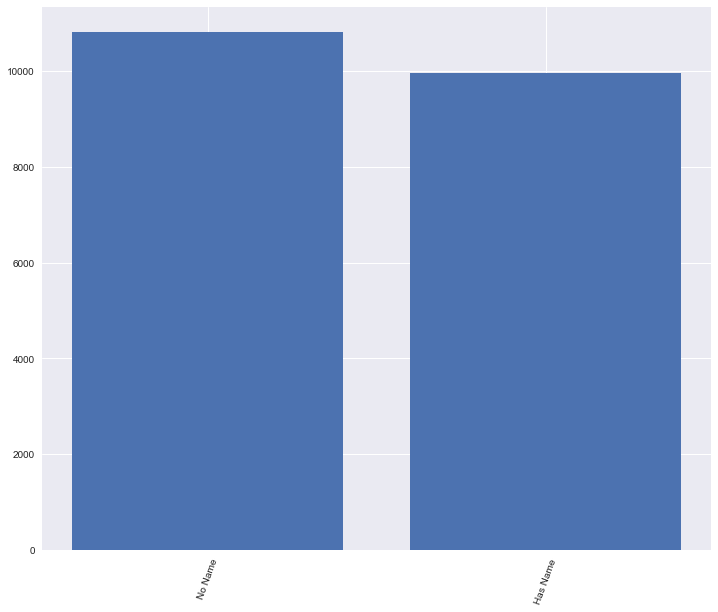

In [86]:
# cats without names
cats_noname = pd.DataFrame(full_dat[full_dat['Species'] == 'Cat']['has_name'].value_counts())
cats_noname = cats_noname.rename(index={0: 'No Name'})
cats_noname = cats_noname.rename(index={1: 'Has Name'})

plt.bar(cats_noname.index, cats_noname['has_name']);
plt.xticks(rotation=70);

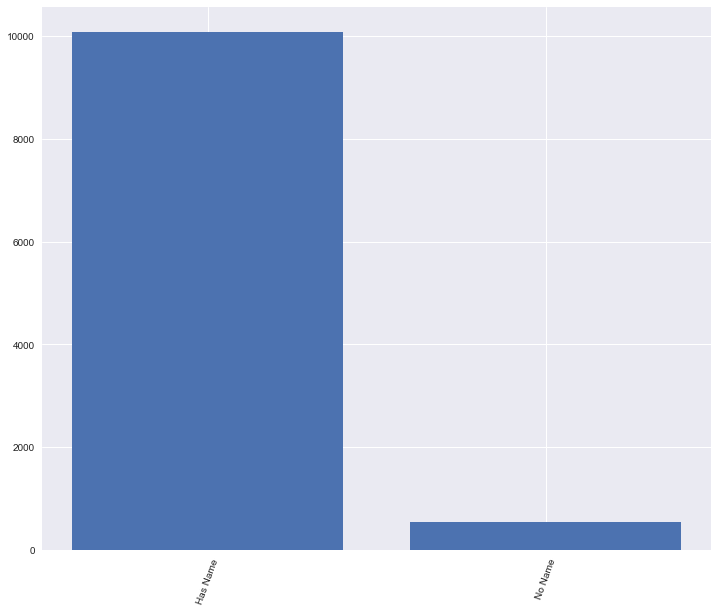

In [87]:
# dogs without names
dogs_noname = pd.DataFrame(full_dat[full_dat['Species'] == 'Dog']['has_name'].value_counts())
dogs_noname = dogs_noname.rename(index={0: 'No Name'})
dogs_noname = dogs_noname.rename(index={1: 'Has Name'})

plt.bar(dogs_noname.index, dogs_noname['has_name']);
plt.xticks(rotation=70);

### Condition

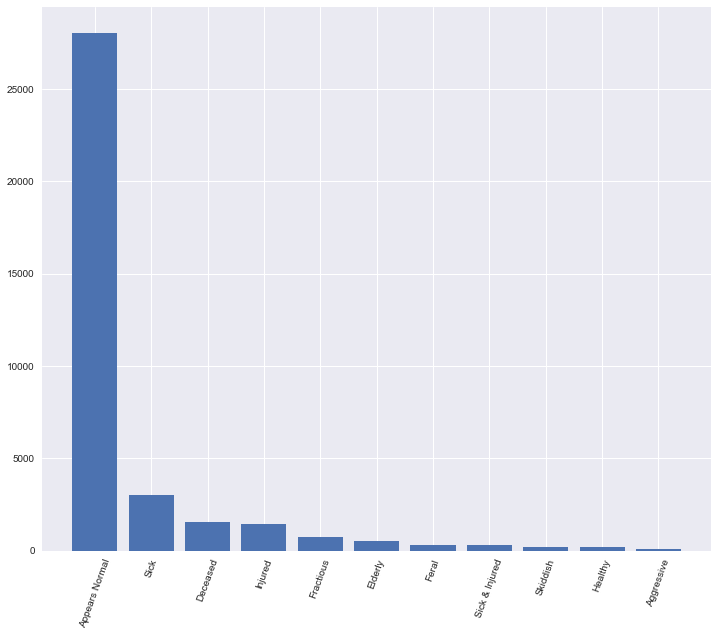

In [88]:
condition = pd.DataFrame(full_dat['Condition'].value_counts())

plt.bar(condition.index, condition['Condition']);
plt.xticks(rotation=70);

# most animals "appear normal"

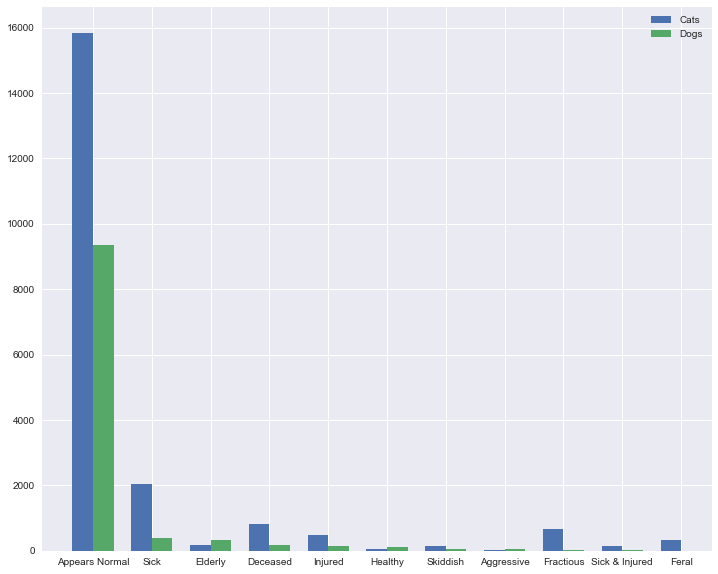

In [90]:
# comparing condition for dogs and cats
dogs_condition = pd.DataFrame(full_dat[full_dat['Species'] == 'Dog']['Condition'].value_counts())
dogs_condition = dogs_condition.rename(columns={"Condition": "Dog Condition"})
cats_condition = pd.DataFrame(full_dat[full_dat['Species'] == 'Cat']['Condition'].value_counts())
cats_condition = cats_condition.rename(columns={"Condition": "Cat Condition"})

both_condition = pd.concat([dogs_condition,cats_condition], axis =1, sort = False)

N = 11

ind = np.arange(N)
width = 0.35       
plt.bar(ind, np.array(both_condition['Cat Condition']), width, label='Cats');
plt.bar(ind + width, np.array(both_condition['Dog Condition']), width,label='Dogs');
plt.xticks(ind + width / 2, both_condition.index);
plt.legend(loc='upper right');


### Intakes Time Analysis

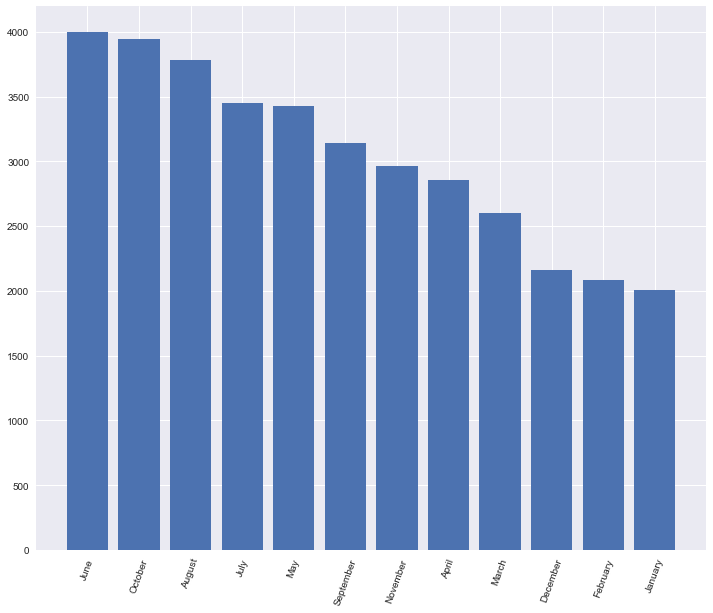

In [91]:
intakesmonth = pd.DataFrame(full_dat['intake_month'].value_counts())

plt.bar(intakesmonth.index, intakesmonth['intake_month']);
plt.xticks(rotation=70);

# june, october, august are top months

### Intake Reasons

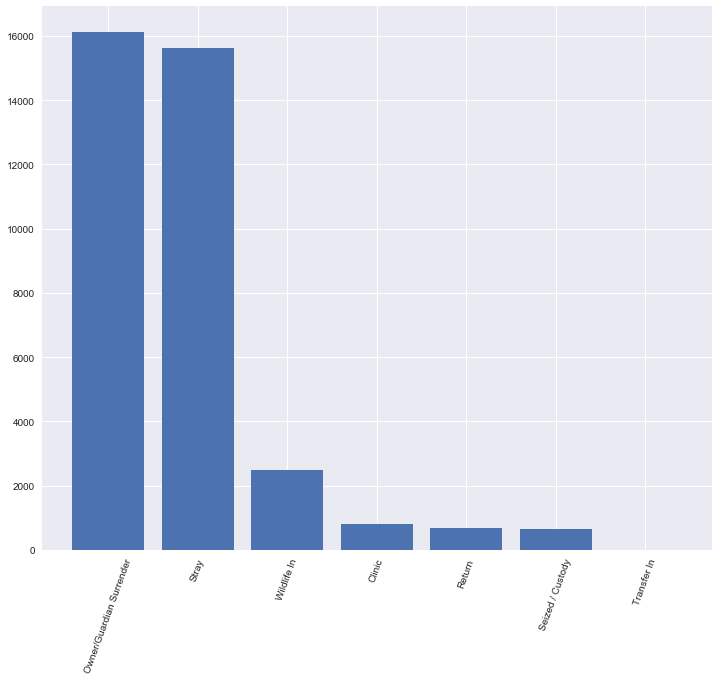

In [93]:
operationtype = pd.DataFrame(full_dat['Operation Type'].value_counts())

plt.bar(operationtype.index, operationtype['Operation Type']);
plt.xticks(rotation=70);

# surrenders and strays are most common

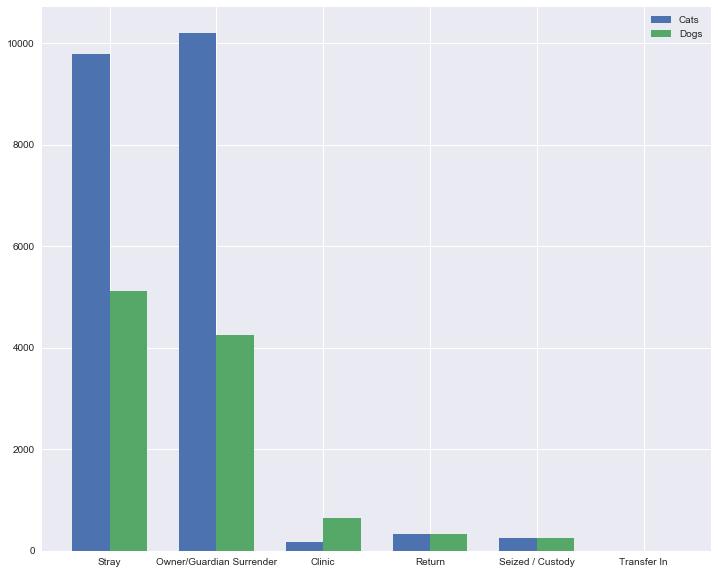

In [94]:
# compare for dogs and cats
dogs_operation = pd.DataFrame(full_dat[full_dat['Species'] == 'Dog']['Operation Type'].value_counts())
dogs_operation = dogs_operation.rename(columns={"Operation Type": "Dog Operation"})
cats_operation = pd.DataFrame(full_dat[full_dat['Species'] == 'Cat']['Operation Type'].value_counts())
cats_operation = cats_operation.rename(columns={"Operation Type": "Cat Operation"})

both_operation = pd.concat([dogs_operation,cats_operation], axis =1, sort = False)

N =6

ind = np.arange(N)
width = 0.35       
plt.bar(ind, np.array(both_operation['Cat Operation']), width, label='Cats');
plt.bar(ind + width, np.array(both_operation['Dog Operation']), width,label='Dogs');
plt.xticks(ind + width / 2, both_operation.index);
plt.legend(loc='upper right');

### Outcomes

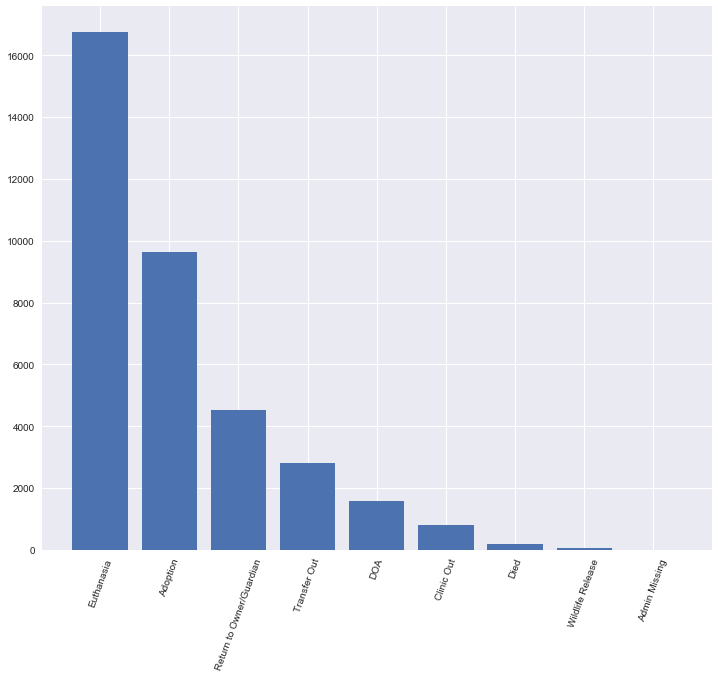

In [95]:
outcomes = pd.DataFrame(full_dat['Outcome Type'].value_counts())

plt.bar(outcomes.index, outcomes['Outcome Type']);
plt.xticks(rotation=70);

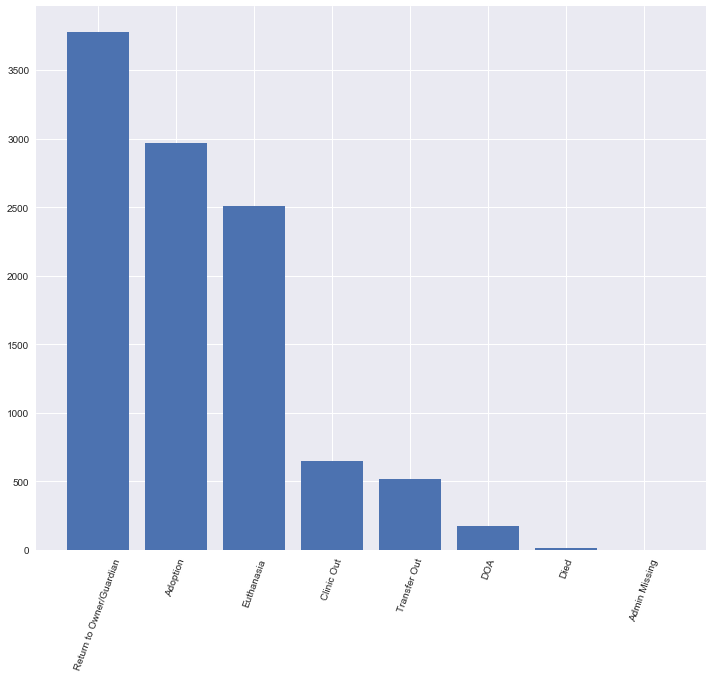

In [96]:
# dog outcomes
dog_outcomes = pd.DataFrame(full_dat[full_dat['Species'] == 'Dog']['Outcome Type'].value_counts())

plt.bar(dog_outcomes.index, dog_outcomes['Outcome Type']);
plt.xticks(rotation=70);

# most are returned to their owner or adopted!

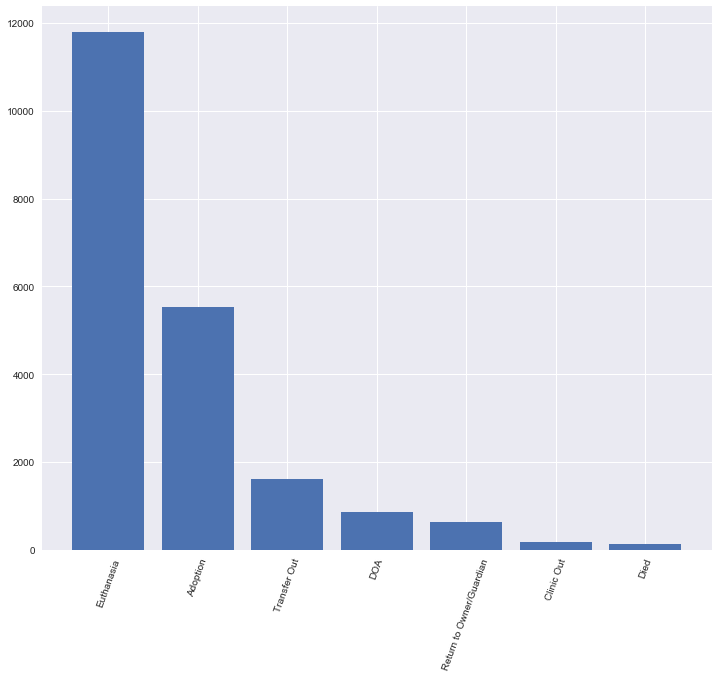

In [97]:
# cat outcomes
cat_outcomes = pd.DataFrame(full_dat[full_dat['Species'] == 'Cat']['Outcome Type'].value_counts())

plt.bar(cat_outcomes.index, cat_outcomes['Outcome Type']);
plt.xticks(rotation=70);

# most are euthanized

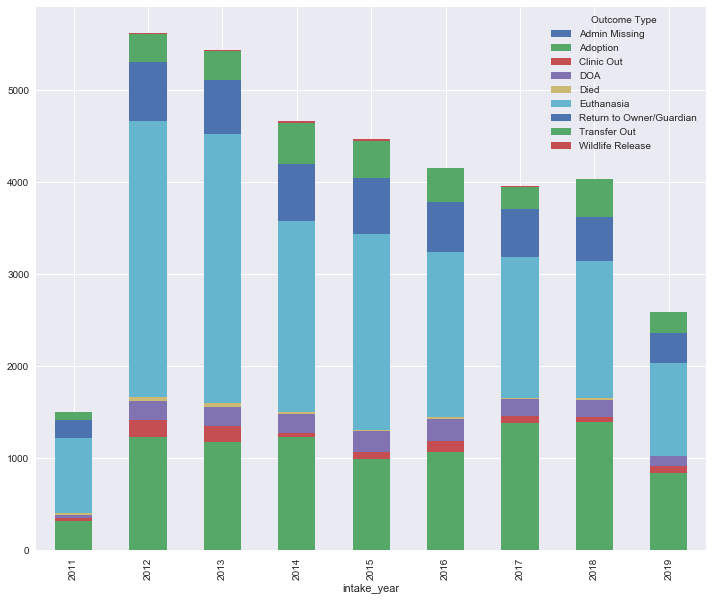

In [98]:
outcomesovertime = full_dat.groupby('intake_year')['Outcome Type'].value_counts().unstack().fillna(0)
outcomesovertime.plot.bar(stacked=True,figsize=(12,10));

# euthanasia is decreasing

### Time of Adoptions

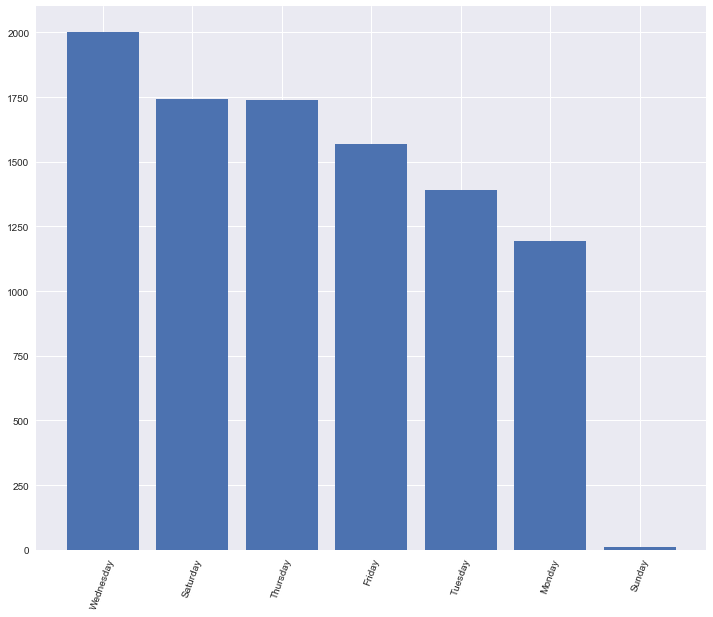

In [99]:
# most popular day of week
outcomes_week = pd.DataFrame(full_dat[full_dat['Outcome Type'] == 'Adoption']['outcome_dayofweek'].value_counts())

plt.bar(outcomes_week.index, outcomes_week['outcome_dayofweek']);
plt.xticks(rotation=70);

# wednesday and saturday are popular days of the week

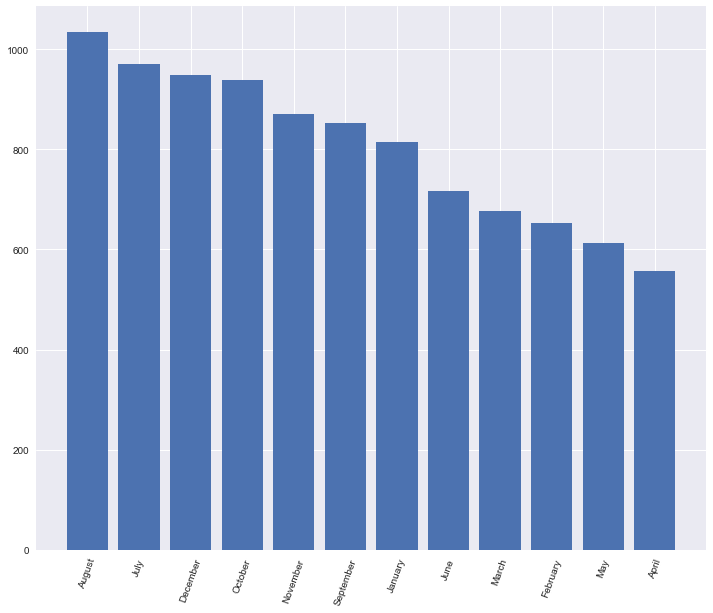

In [100]:
# most popular months
outcomes_month = pd.DataFrame(full_dat[full_dat['Outcome Type'] == 'Adoption']['outcome_month'].value_counts())

plt.bar(outcomes_month.index, outcomes_month['outcome_month']);
plt.xticks(rotation=70);

# august, july, december, common months for adoptions

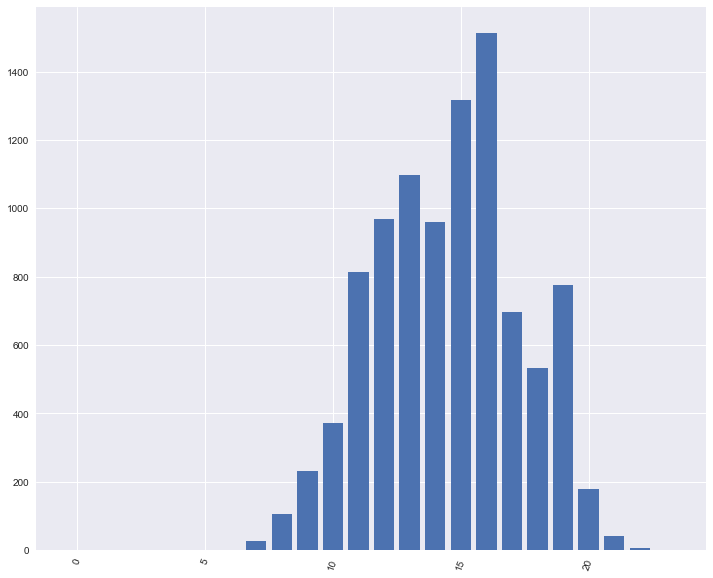

In [101]:
# most popular hour of day
outcomes_hour = pd.DataFrame(full_dat[full_dat['Outcome Type'] == 'Adoption']['outcome_hour'].value_counts())

plt.bar(outcomes_hour.index, outcomes_hour['outcome_hour']);
plt.xticks(rotation=70);

# evening hours are most popular

In [102]:
df_heat = full_dat[full_dat['Outcome Type'] == 'Adoption'].groupby(["outcome_hour", "outcome_dayofweek"]).size().reset_index()

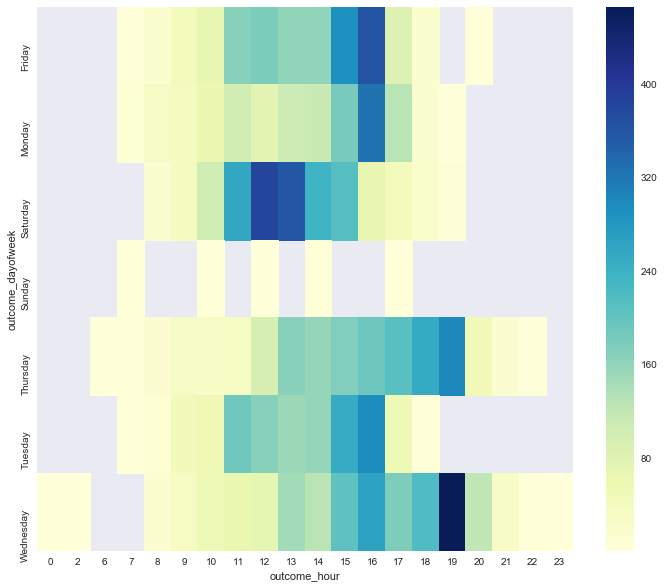

In [104]:
# heat map of day of week and hour of day
import seaborn as sns
heatmap_data = pd.pivot_table(df_heat, values=0, 
                     index=['outcome_dayofweek'], 
                     columns='outcome_hour')

sns.heatmap(heatmap_data, cmap="YlGnBu");

# wednesday evening and saturday afternoon look the most popular

## Relationships with Outcome

### Outcome and Spayed/Neutered

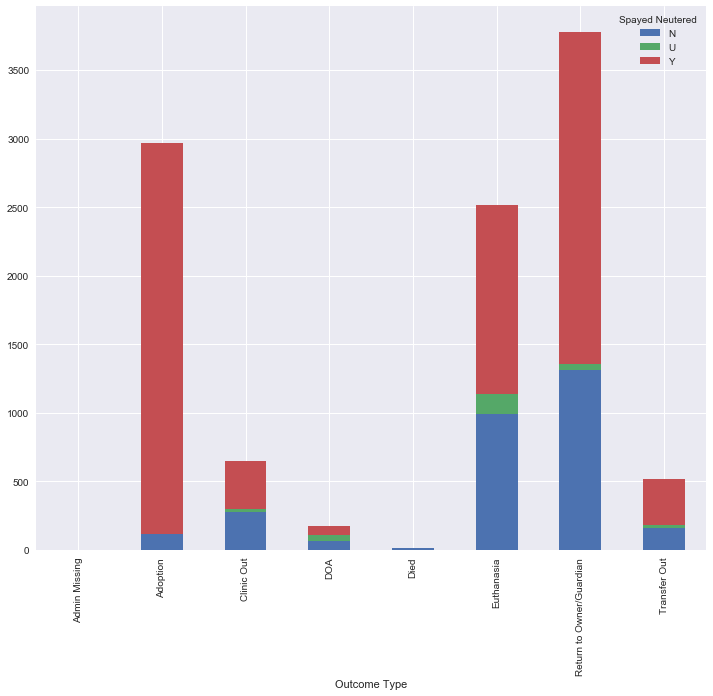

In [106]:
# outcome and speyed/neutered for dogs
outcome_SN_dog = full_dat[full_dat['Species'] == 'Dog'].groupby('Outcome Type')['Spayed Neutered'].value_counts().unstack().fillna(0)
outcome_SN_dog.plot.bar(stacked=True,figsize=(12,10));

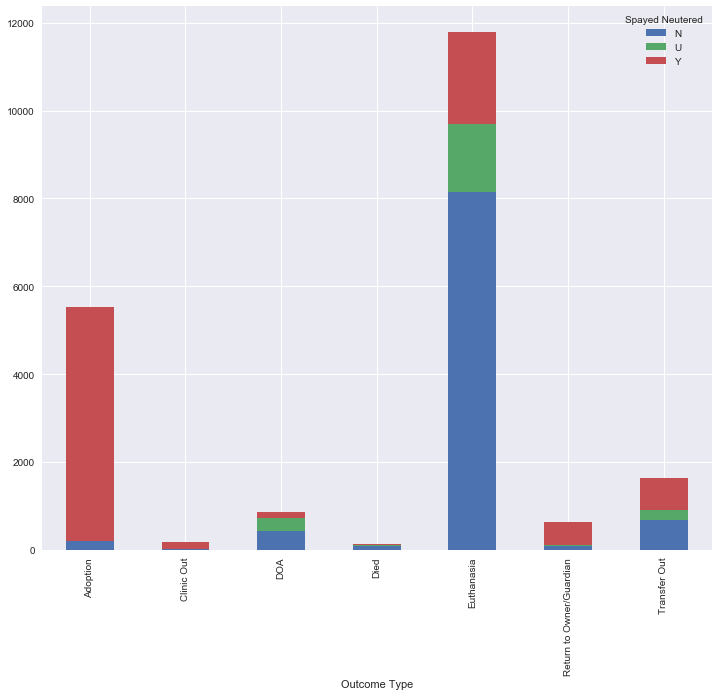

In [107]:
# outcome and speyed/neutered for cats
outcome_SN_cat = full_dat[full_dat['Species'] == 'Cat'].groupby('Outcome Type')['Spayed Neutered'].value_counts().unstack().fillna(0)
outcome_SN_cat.plot.bar(stacked=True,figsize=(12,10));

### Outcome and Age Group

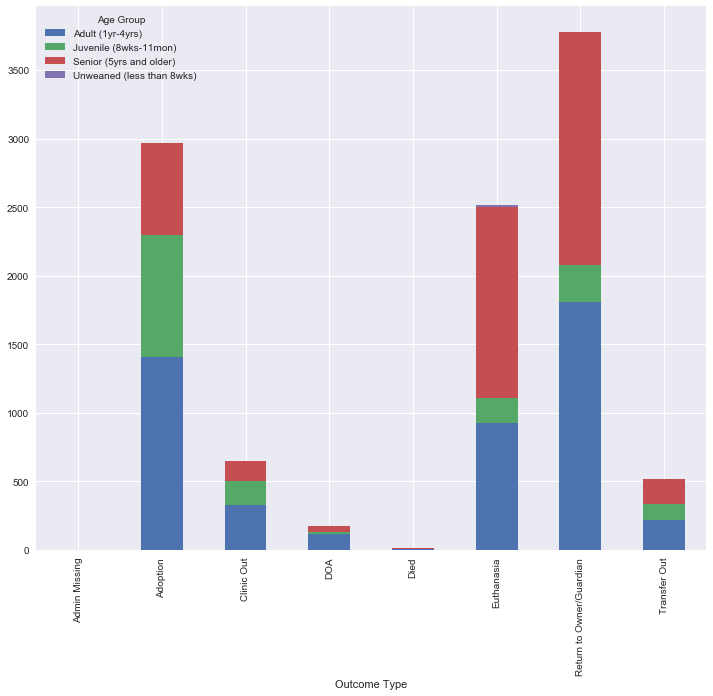

In [105]:
# outcome and age for dogs
outcome_age_dog = full_dat[full_dat['Species'] == 'Dog'].groupby('Outcome Type')['Age Group'].value_counts().unstack().fillna(0)
outcome_age_dog.plot.bar(stacked=True,figsize=(12,10));

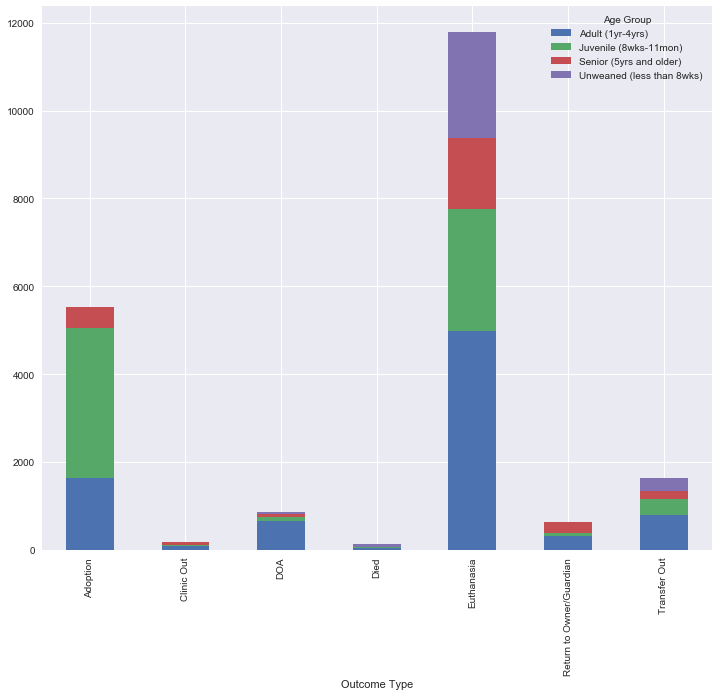

In [39]:
# outcome and age for cats
outcome_age_cat = full_dat[full_dat['Species'] == 'Cat'].groupby('Outcome Type')['Age Group'].value_counts().unstack().fillna(0)

outcome_age_cat.plot.bar(stacked=True,figsize=(12,10));

### Outcome and Gender

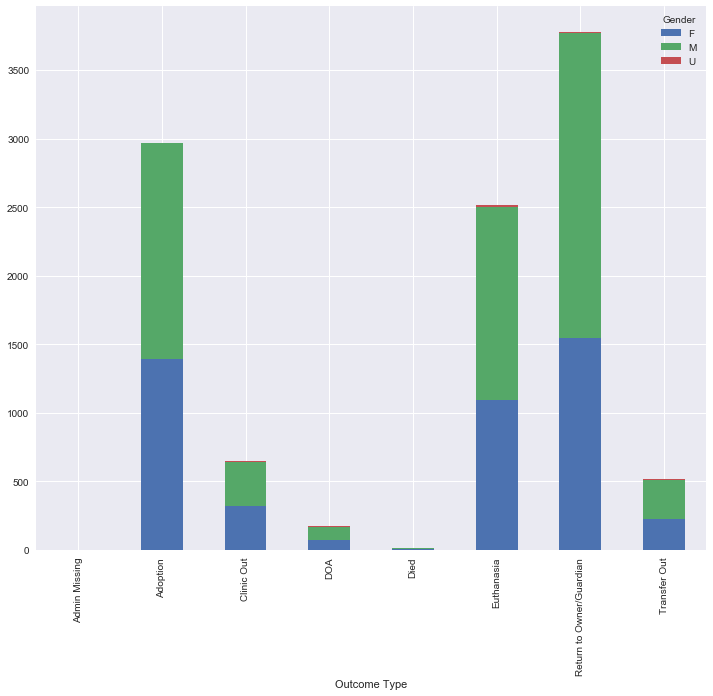

In [40]:
# outcome and gender for dogs
outcome_gender_dog = full_dat[full_dat['Species'] == 'Dog'].groupby('Outcome Type')['Gender'].value_counts().unstack().fillna(0)
outcome_gender_dog.plot.bar(stacked=True,figsize=(12,10));

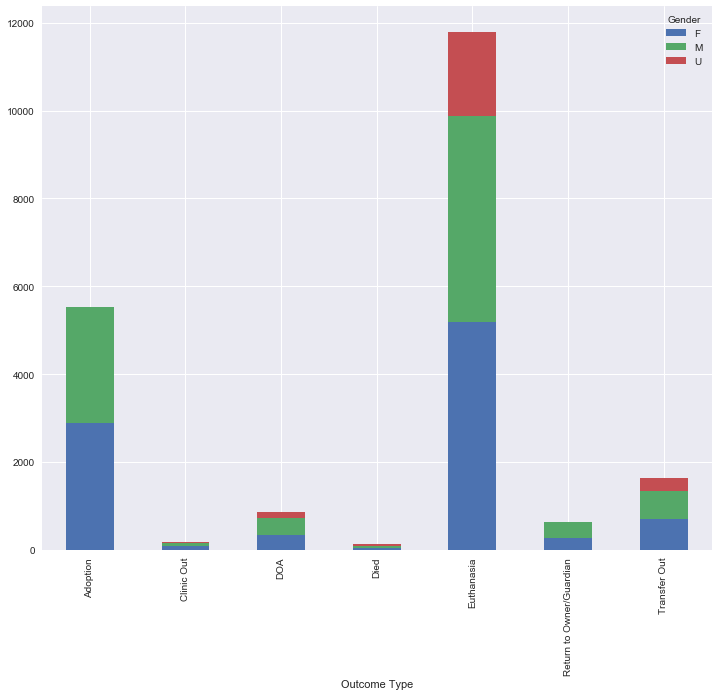

In [41]:
# outcome and gender for cats
outcome_gender_cat = full_dat[full_dat['Species'] == 'Cat'].groupby('Outcome Type')['Gender'].value_counts().unstack().fillna(0)
outcome_gender_cat.plot.bar(stacked=True,figsize=(12,10));


### Outcome and Black Color

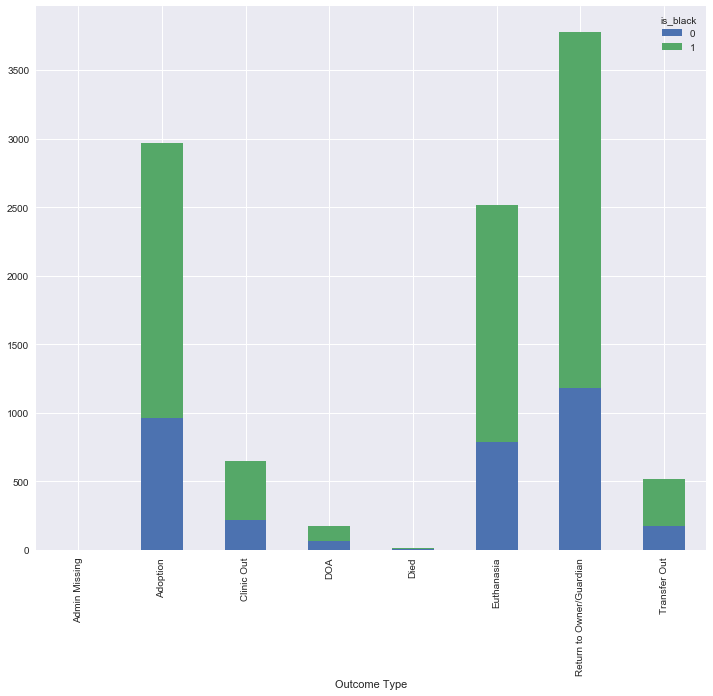

In [48]:
outcome_black_dog = full_dat[full_dat['Species'] == 'Dog'].groupby('Outcome Type')['is_black'].value_counts().unstack().fillna(0)

outcome_black_dog.plot.bar(stacked=True,figsize=(12,10));

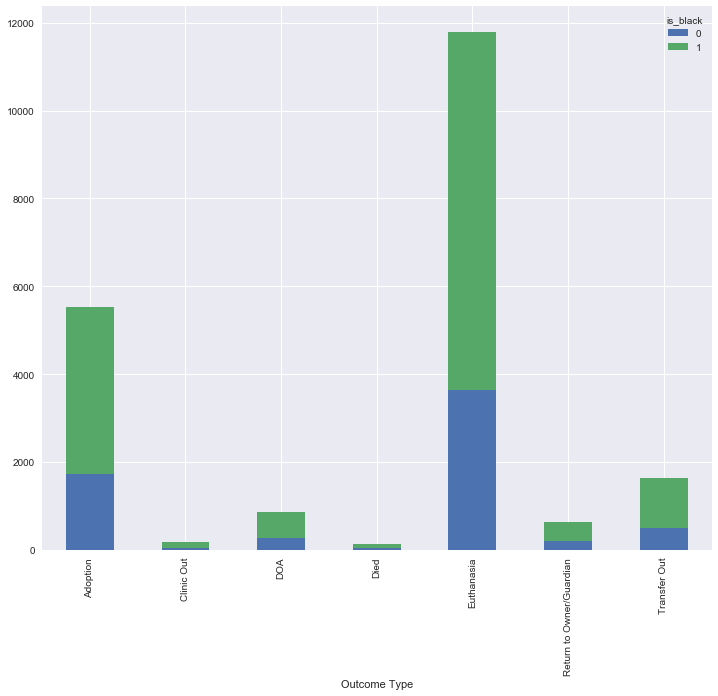

In [49]:
outcome_black_cat = full_dat[full_dat['Species'] == 'Cat'].groupby('Outcome Type')['is_black'].value_counts().unstack().fillna(0)
outcome_black_cat.plot.bar(stacked=True,figsize=(12,10));

### Outcome and Size

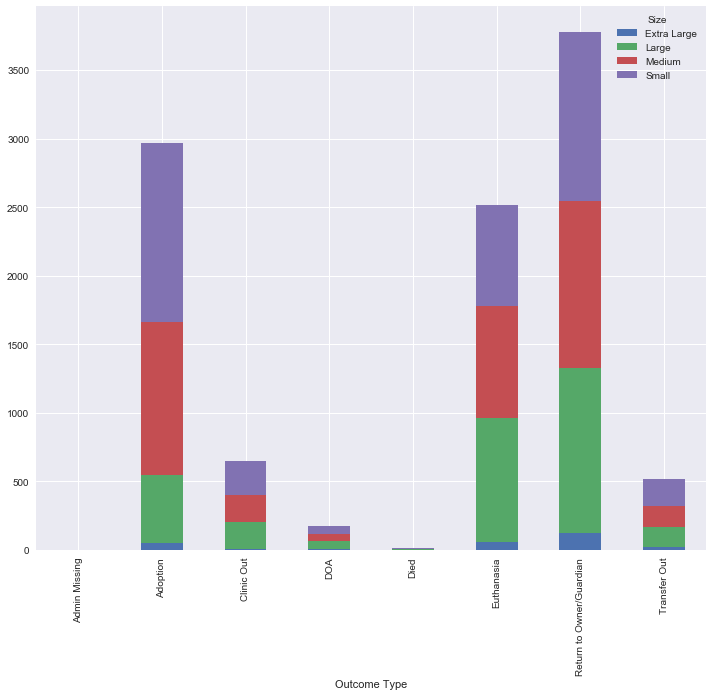

In [91]:
outcome_size_dog = full_dat[full_dat['Species'] == 'Dog'].groupby('Outcome Type')['Size'].value_counts().unstack().fillna(0)

outcome_size_dog.plot.bar(stacked=True,figsize=(12,10));


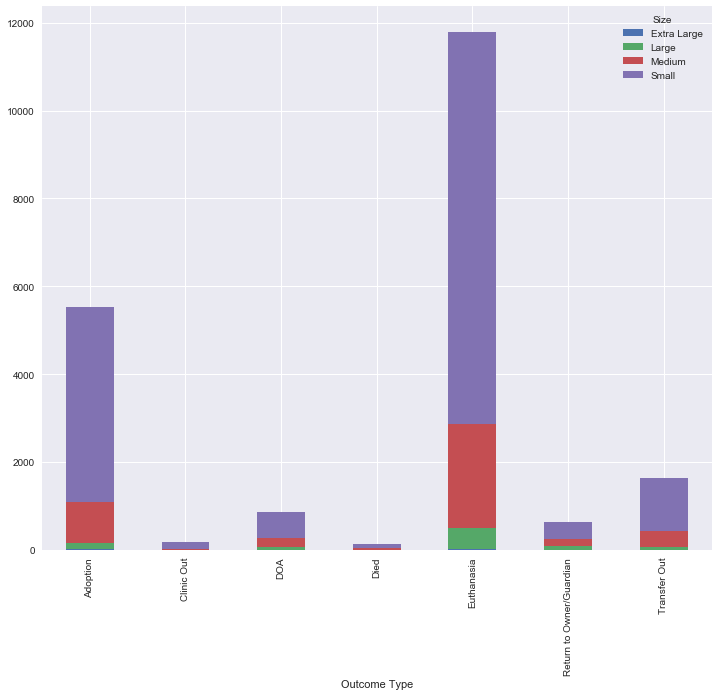

In [92]:
outcome_size_cat = full_dat[full_dat['Species'] == 'Cat'].groupby('Outcome Type')['Size'].value_counts().unstack().fillna(0)

outcome_size_cat.plot.bar(stacked=True,figsize=(12,10));


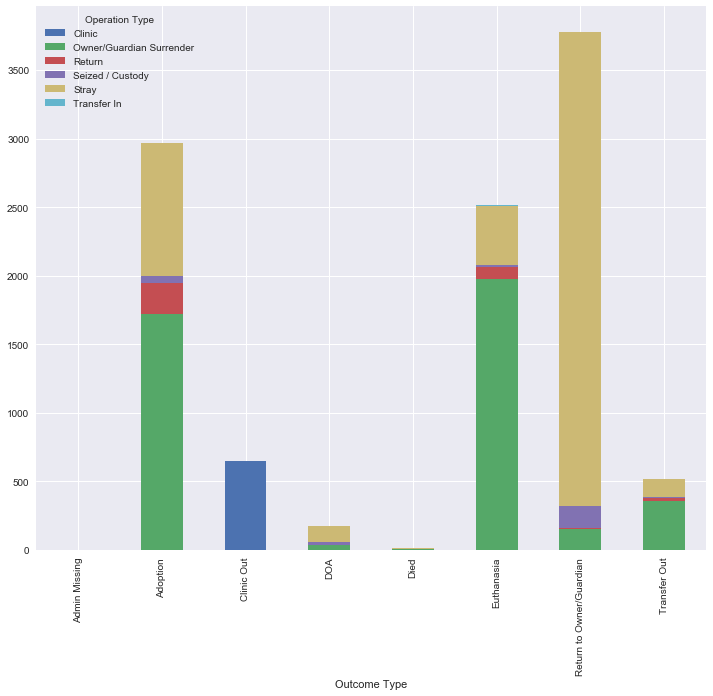

In [95]:
outcome_intakereason_dog = full_dat[full_dat['Species'] == 'Dog'].groupby('Outcome Type')['Operation Type'].value_counts().unstack().fillna(0)
outcome_intakereason_dog.plot.bar(stacked=True,figsize=(12,10));

# strays are almost always returned to owner

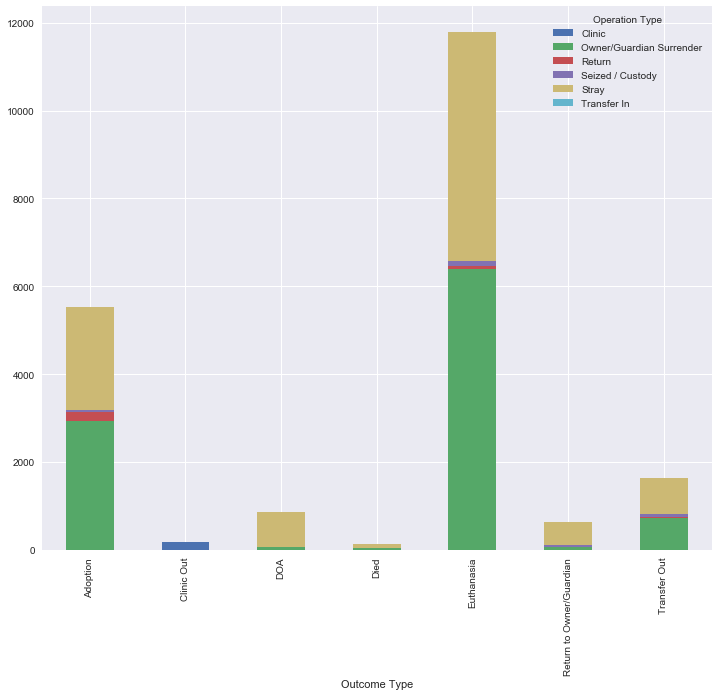

In [96]:
outcome_intakereason_cat = full_dat[full_dat['Species'] == 'Cat'].groupby('Outcome Type')['Operation Type'].value_counts().unstack().fillna(0)
outcome_intakereason_cat.plot.bar(stacked=True,figsize=(12,10));

# most strays get euthanized for cats

### Success Rates (adoption or return to owner)

In [108]:
dogbreedcounts = pd.DataFrame(full_dat[full_dat['Species'] == 'Dog']['Primary Breed'].value_counts()).sort_values(by = 'Primary Breed', ascending=False)[:20]
dogbreedadoptions = full_dat[(full_dat['Species'] == 'Dog') & (full_dat['Outcome Type'].isin(['Adoption','Return to Owner/Guardian']))]['Primary Breed'].value_counts()

dogbreed_final = pd.merge(left=dogbreedcounts,right=dogbreedadoptions, how='left', left_on=dogbreedcounts.index, right_on=dogbreedadoptions.index)
dogbreed_final['Success Rate'] = dogbreed_final['Primary Breed_y']/dogbreed_final['Primary Breed_x']

dogbreed_final = dogbreed_final.sort_values(by = 'Success Rate', ascending = False)
dogbreed_final

,key_0,Primary Breed_x,Primary Breed_y,Success Rate
12,Siberian Husky,212,162,0.764151
11,Hound,213,156,0.732394
2,Beagle,667,485,0.727136
7,Shih Tzu,328,228,0.695122
3,"Chihuahua, Short Coat",493,341,0.691684
1,"Retriever, Labrador",1128,780,0.691489
15,"Retriever, Golden",180,124,0.688889
5,"Terrier, Jack Russell",344,231,0.671512
14,Pomeranian,182,122,0.670330
6,Terrier,328,219,0.667683


In [109]:
catbreedcounts = pd.DataFrame(full_dat[full_dat['Species'] == 'Cat']['Primary Breed'].value_counts()).sort_values(by = 'Primary Breed', ascending=False)[:10]
catbreedadoptions = full_dat[(full_dat['Species'] == 'Cat') & (full_dat['Outcome Type'].isin(['Adoption','Return to Owner/Guardian']))]['Primary Breed'].value_counts()

catbreed_final = pd.merge(left=catbreedcounts,right=catbreedadoptions, how='left', left_on=catbreedcounts.index, right_on=catbreedadoptions.index)
catbreed_final['Success Rate'] = catbreed_final['Primary Breed_y']/catbreed_final['Primary Breed_x']

catbreed_final = catbreed_final.sort_values(by = 'Success Rate', ascending = False)

catbreed_final

,key_0,Primary Breed_x,Primary Breed_y,Success Rate
5,Maine Coon,28,15,0.535714
4,Himalayan,56,27,0.482143
8,Ragdoll,19,9,0.473684
3,Siamese,205,78,0.380488
6,Persian,26,9,0.346154
1,Domestic Medium Hair,1794,607,0.338350
7,Snowshoe,22,7,0.318182
9,Manx,16,5,0.312500
0,Domestic Shorthair,17976,5253,0.292223
2,Domestic Longhair,537,149,0.277467


### Euthanasia Rates

In [110]:
dogbreedeuth = full_dat[(full_dat['Species'] == 'Dog') & (full_dat['Outcome Type'].isin(['Euthanasia']))]['Primary Breed'].value_counts()

dogbreed_final = pd.merge(left=dogbreedcounts,right=dogbreedeuth, how='left', left_on=dogbreedcounts.index, right_on=dogbreedeuth.index)
dogbreed_final['Euthanasia Rate'] = dogbreed_final['Primary Breed_y']/dogbreed_final['Primary Breed_x']

dogbreed_final = dogbreed_final.sort_values(by = 'Euthanasia Rate', ascending = False)
dogbreed_final

,key_0,Primary Breed_x,Primary Breed_y,Euthanasia Rate
13,Rottweiler,184,76,0.413043
0,"Terrier, Pit Bull",1750,611,0.349143
18,"Poodle, Miniature",131,39,0.297710
10,Shepherd,251,74,0.294821
9,Boxer,258,68,0.263566
4,German Shepherd,393,101,0.256997
5,"Terrier, Jack Russell",344,86,0.250000
19,Australian Cattle Dog,104,25,0.240385
2,Beagle,667,135,0.202399
6,Terrier,328,65,0.198171


### Most Common Name in Each Year

In [115]:
years = [2011,2012,2013,2014,2015,2016,2017,2018,2019]
topnames = []
for y in years:
    topnames.append(pd.DataFrame(full_dat[(full_dat['Species'] == 'Dog') & (full_dat['intake_year'] == y)]['Animal Name'].value_counts()).sort_values(by = 'Animal Name', ascending=False)[1:2].index[0])

topnames

['MAX', 'MAX', 'BELLA', 'BELLA', 'MAX', 'MAX', 'ACE', 'MAX', 'LUNA']

In [116]:
years = [2011,2012,2013,2014,2015,2016,2017,2018,2019]
topnames = []
for y in years:
    topnames.append(pd.DataFrame(full_dat[(full_dat['Species'] == 'Cat') & (full_dat['intake_year'] == y)]['Animal Name'].value_counts()).sort_values(by = 'Animal Name', ascending=False)[1:2].index[0])

topnames

['KITTY',
 'TIGER',
 'KITTY',
 'SHADOW',
 'OREO',
 'PRECIOUS',
 'SMOKEY',
 'OREO',
 'BELLA']

## Visualizing Jurisdiction

In [117]:
import json
with open('maryland-zips.geojson', 'r') as jsonFile:
    data = json.load(jsonFile)
    
tmp = data

In [118]:
geozips = []

for i in range(len(tmp['features'])):
    if tmp['features'][i]['properties']['name'] in list(full_dat['clean_jurisdiction'].unique()):
        geozips.append(tmp['features'][i])
        

In [119]:
new_json = dict.fromkeys(['type','features'])
new_json['type'] = 'FeatureCollection'
new_json['features'] = geozips

In [120]:
# taken from https://towardsdatascience.com/visualizing-data-at-the-zip-code-level-with-folium-d07ac983db20
import folium

# table = main table/data frame we read from (pandas DataFrame)
# zips = column name where ZIP codes are (string)
# mapped_feature = column name for feature we want to visualize (string)
# add_text = any additional commentary to be added in the map legend (string)

def create_map(table, zips, mapped_feature,add_text = ''):
    

    # reading of the updated GeoJSON file
    md_geo = new_json
    # initiating a Folium map with LA's longitude and latitude
    m = folium.Map(location = [39.4143 , -77.4105], zoom_start = 11)
    # creating a choropleth map
    m.choropleth(
        geo_data = md_geo,
        fill_opacity = 0.7,
        line_opacity = 0.2,
        data = table,
        # refers to which key within the GeoJSON to map the ZIP code to
        key_on = 'feature.properties.name',
        # first element contains location information, second element contains feature of interest
        columns = [zips, mapped_feature],
        fill_color = 'RdYlGn',
        legend_name = (' ').join(mapped_feature.split('_')).title() + ' ' + add_text + ' Across MD'
    )
    folium.LayerControl().add_to(m)
    # save map with filename based on the feature of interest
    m.save(outfile = mapped_feature + '_map_cat.html')

In [121]:
dog_jurisdiction = pd.DataFrame(full_dat[full_dat['Species'] == 'Dog']['clean_jurisdiction'].value_counts())

cat_jurisdiction = pd.DataFrame(full_dat[full_dat['Species'] == 'Cat']['clean_jurisdiction'].value_counts())

In [122]:
create_map(cat_jurisdiction[1:], cat_jurisdiction[1:].index, 'clean_jurisdiction', add_text = '')

/Users/kaitlynlongo/anaconda3/lib/python3.7/site-packages/folium/folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


In [123]:
create_map(dog_jurisdiction[1:], dog_jurisdiction[1:].index, 'clean_jurisdiction', add_text = '')

### Jurisdiction over Time

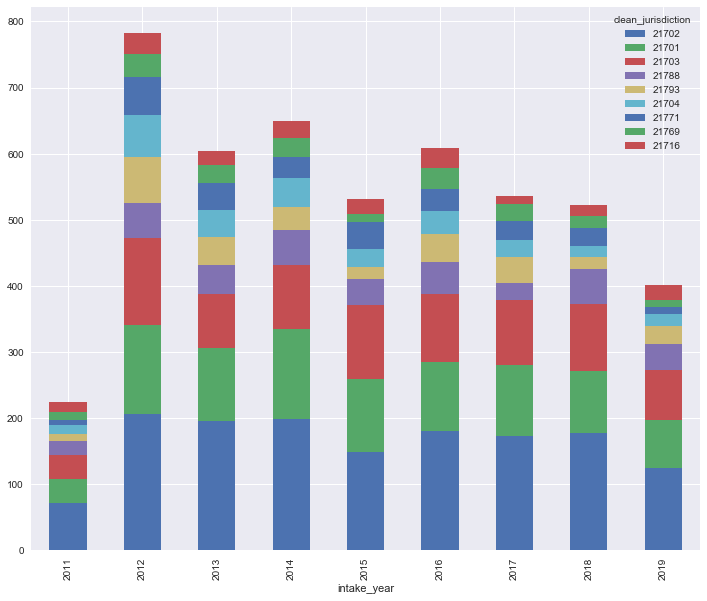

In [124]:
juris_over_time = full_dat[full_dat['Species'] == 'Dog'].groupby('intake_year')['clean_jurisdiction'].value_counts().unstack().fillna(0)

topjuris = pd.DataFrame(full_dat[full_dat['Species'] == 'Dog']['clean_jurisdiction'].value_counts()).sort_values(by = 'clean_jurisdiction', ascending=False)[:10]
topjuris = list(topjuris.index[1:])

juris_over_time = juris_over_time.filter(items = topjuris)
juris_over_time.plot.bar(stacked=True,figsize=(12,10));


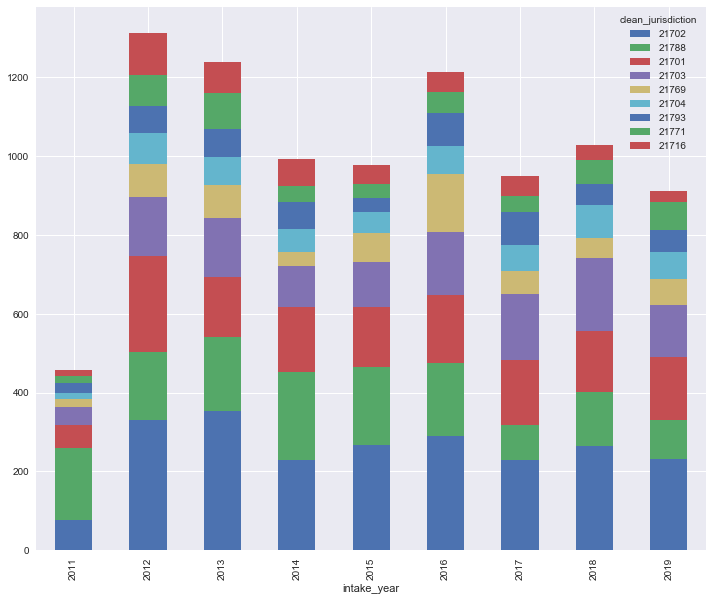

In [125]:
# for cats
juris_over_time = full_dat[full_dat['Species'] == 'Cat'].groupby('intake_year')['clean_jurisdiction'].value_counts().unstack().fillna(0)

topjuris = pd.DataFrame(full_dat[full_dat['Species'] == 'Cat']['clean_jurisdiction'].value_counts()).sort_values(by = 'clean_jurisdiction', ascending=False)[:10]
topjuris = list(topjuris.index[1:])

juris_over_time = juris_over_time.filter(items = topjuris)
juris_over_time.plot.bar(stacked=True,figsize=(12,10));


## Jurisdiction and Pre-Altered

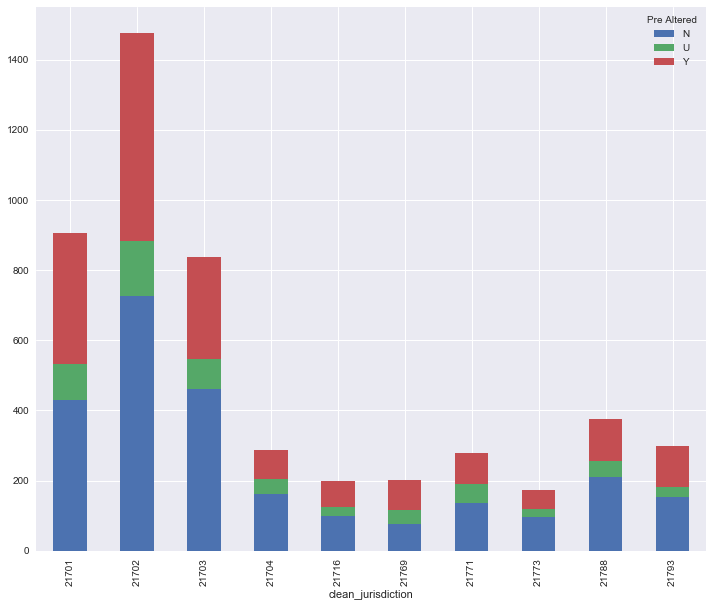

In [126]:
topdogzips = pd.DataFrame(full_dat[full_dat['Species'] == 'Dog']['clean_jurisdiction'].value_counts()).sort_values(by = 'clean_jurisdiction', ascending=False)[:11]
topdogzips = topdogzips.index[1:]

# outcome and speyed/neutered for dogs
topdogzips_df = full_dat[full_dat['Species'] == 'Dog'].groupby('clean_jurisdiction')['Pre Altered'].value_counts().unstack().fillna(0)

topdogzips_dffinal = topdogzips_df[topdogzips_df.index.isin(topdogzips)]

topdogzips_dffinal.plot.bar(stacked=True,figsize=(12,10));

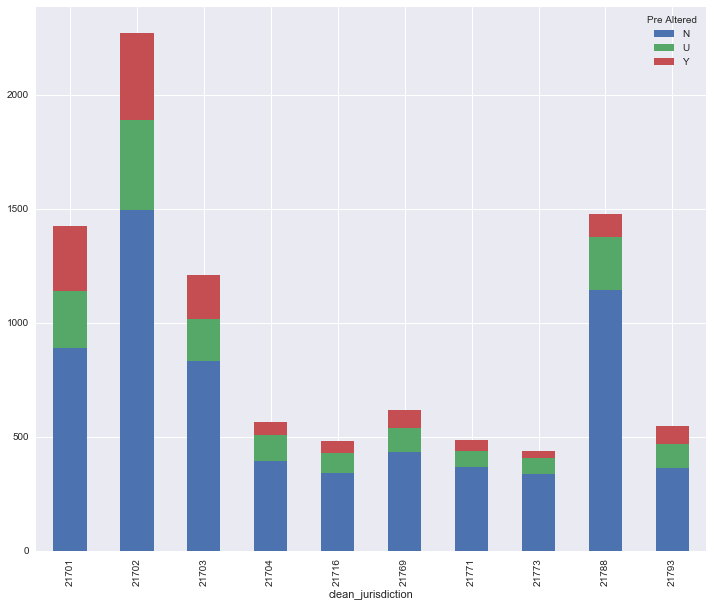

In [127]:
topcatzips = pd.DataFrame(full_dat[full_dat['Species'] == 'Cat']['clean_jurisdiction'].value_counts()).sort_values(by = 'clean_jurisdiction', ascending=False)[:11]
topcatzips = topcatzips.index[1:]

# outcome and speyed/neutered for dogs
topcatzips_df = full_dat[full_dat['Species'] == 'Cat'].groupby('clean_jurisdiction')['Pre Altered'].value_counts().unstack().fillna(0)

topcatzips_dffinal = topcatzips_df[topcatzips_df.index.isin(topcatzips)]

topcatzips_dffinal.plot.bar(stacked=True,figsize=(12,10));


### Where do Strays Come From?

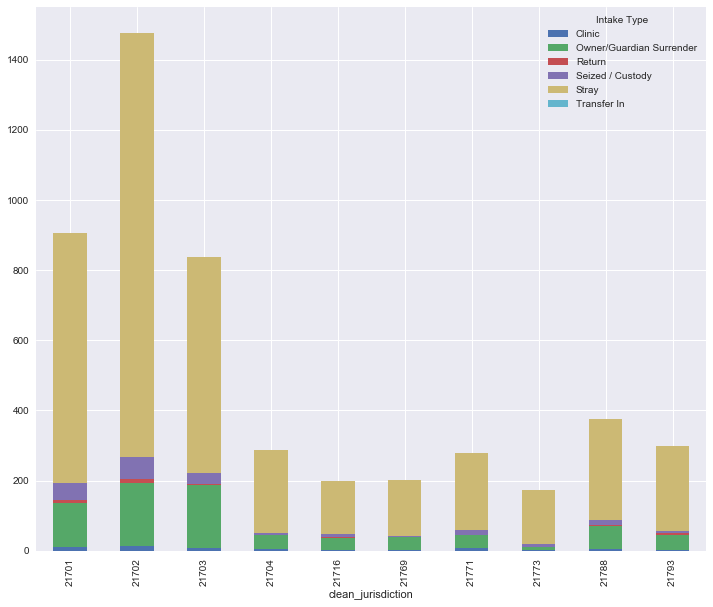

In [128]:
# dogs
topdogzips = pd.DataFrame(full_dat[full_dat['Species'] == 'Dog']['clean_jurisdiction'].value_counts()).sort_values(by = 'clean_jurisdiction', ascending=False)[:11]
topdogzips = topdogzips.index[1:]

# outcome and speyed/neutered for dogs
topdogzips_df = full_dat[full_dat['Species'] == 'Dog'].groupby('clean_jurisdiction')['Intake Type'].value_counts().unstack().fillna(0)

topdogzips_dffinal = topdogzips_df[topdogzips_df.index.isin(topdogzips)]

topdogzips_dffinal.plot.bar(stacked=True,figsize=(12,10));

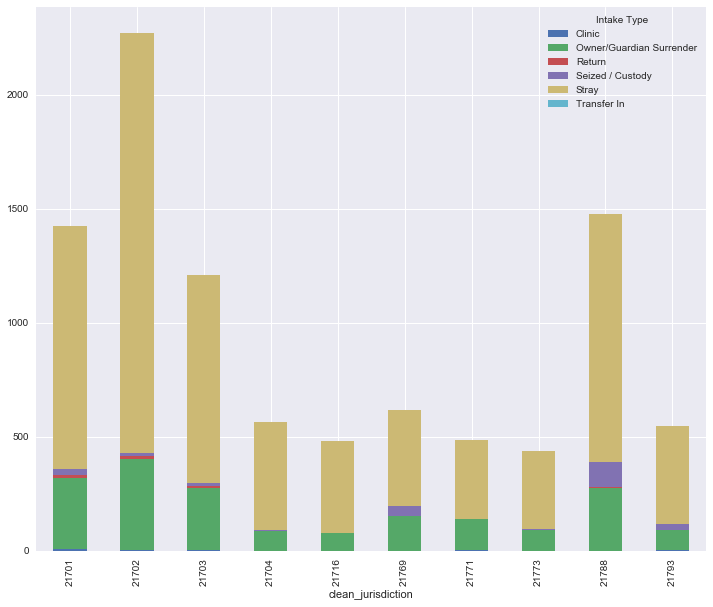

In [129]:
# cats
topcatzips = pd.DataFrame(full_dat[full_dat['Species'] == 'Cat']['clean_jurisdiction'].value_counts()).sort_values(by = 'clean_jurisdiction', ascending=False)[:11]
topcatzips = topcatzips.index[1:]

# outcome and speyed/neutered for dogs
topcatzips_df = full_dat[full_dat['Species'] == 'Cat'].groupby('clean_jurisdiction')['Intake Type'].value_counts().unstack().fillna(0)

topcatzips_dffinal = topcatzips_df[topcatzips_df.index.isin(topcatzips)]

topcatzips_dffinal.plot.bar(stacked=True,figsize=(12,10));

## Time in Shelter

In [130]:
time_in_shelter = full_dat['time_in_shelter'][full_dat['time_in_shelter'] > pd.Timedelta(hours=0)].dropna()
time_in_shelter.describe()

count                      34693
mean     15 days 05:47:54.579886
std      29 days 06:31:45.420930
min              0 days 00:01:00
25%              0 days 16:48:00
50%              4 days 15:53:00
75%             15 days 01:10:00
max            480 days 16:56:00
Name: time_in_shelter, dtype: object

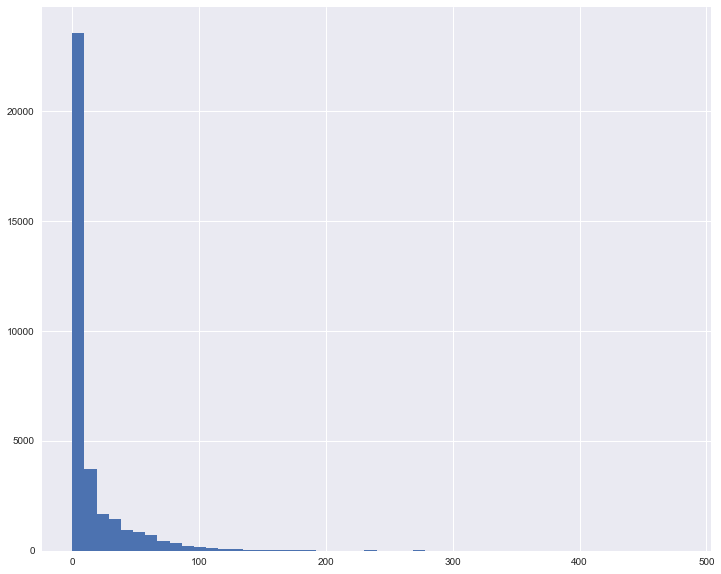

In [131]:
time_in_shelter_days = time_in_shelter.astype('timedelta64[D]')
time_in_shelter_days.hist(bins=50)

### Dog Adoptions

In [134]:
dogadoptions = full_dat[(full_dat['Species'] == 'Dog') & (full_dat['Outcome Type'].isin(['Adoption']))]
time_in_shelter = dogadoptions['time_in_shelter'][dogadoptions['time_in_shelter'] >= pd.Timedelta(hours=0)].dropna()

time_in_shelter.describe()

count                       2969
mean     22 days 23:13:13.297406
std      26 days 06:12:16.531245
min              0 days 00:10:00
25%              9 days 18:53:00
50%             15 days 07:15:00
75%             27 days 05:20:00
max            480 days 16:56:00
Name: time_in_shelter, dtype: object

### Dog Return to Owner

In [135]:
dogreturns = full_dat[(full_dat['Species'] == 'Dog') & (full_dat['Outcome Type'].isin(['Return to Owner/Guardian']))]
time_in_shelter = dogreturns['time_in_shelter'][dogreturns['time_in_shelter'] >= pd.Timedelta(hours=0)].dropna()

time_in_shelter.describe()

count                      3776
mean     1 days 06:26:01.016949
std      2 days 04:20:40.078255
min             0 days 00:00:00
25%             0 days 04:04:00
50%             0 days 18:01:00
75%             1 days 08:31:45
max            35 days 21:52:00
Name: time_in_shelter, dtype: object

### Dog Euthanasia

In [136]:
dogeuthanasia = full_dat[(full_dat['Species'] == 'Dog') & (full_dat['Outcome Type'].isin(['Euthanasia']))]
time_in_shelter = dogeuthanasia['time_in_shelter'][dogeuthanasia['time_in_shelter'] >= pd.Timedelta(hours=0)].dropna()

time_in_shelter.describe()

count                       2512
mean      4 days 11:24:14.761146
std      11 days 10:42:38.132571
min              0 days 00:00:00
25%              0 days 00:30:00
50%              1 days 00:59:00
75%              6 days 01:01:45
max            365 days 00:41:00
Name: time_in_shelter, dtype: object

### Cat Adoptions

In [137]:
catadoptions = full_dat[(full_dat['Species'] == 'Cat') & (full_dat['Outcome Type'].isin(['Adoption']))]
time_in_shelter = catadoptions['time_in_shelter'][catadoptions['time_in_shelter'] >= pd.Timedelta(hours=0)].dropna()

time_in_shelter.describe()

count                       5538
mean     49 days 04:52:59.761646
std      35 days 13:44:36.184463
min              0 days 00:04:00
25%             24 days 04:04:45
50%             42 days 21:56:00
75%             65 days 01:25:15
max            442 days 08:12:00
Name: time_in_shelter, dtype: object

### Cat Return to Owner

In [138]:
catreturns = full_dat[(full_dat['Species'] == 'Cat') & (full_dat['Outcome Type'].isin(['Return to Owner/Guardian']))]
time_in_shelter = catreturns['time_in_shelter'][catreturns['time_in_shelter'] >= pd.Timedelta(hours=0)].dropna()

time_in_shelter.describe()

count                        642
mean      4 days 02:48:32.897196
std      12 days 23:30:25.670002
min              0 days 00:02:00
25%              0 days 16:41:30
50%              1 days 13:13:30
75%              3 days 21:08:15
max            222 days 06:47:00
Name: time_in_shelter, dtype: object

### Cat Euthanasia

In [139]:
cateuthanasia = full_dat[(full_dat['Species'] == 'Cat') & (full_dat['Outcome Type'].isin(['Euthanasia']))]
time_in_shelter = cateuthanasia['time_in_shelter'][cateuthanasia['time_in_shelter'] >= pd.Timedelta(hours=0)].dropna()

time_in_shelter.describe()

count                      11785
mean      5 days 15:34:54.730589
std      17 days 06:26:22.119164
min              0 days 00:01:00
25%              0 days 18:34:00
50%              2 days 22:52:00
75%              6 days 04:05:00
max            370 days 00:33:00
Name: time_in_shelter, dtype: object

### Relationship between time and outcome

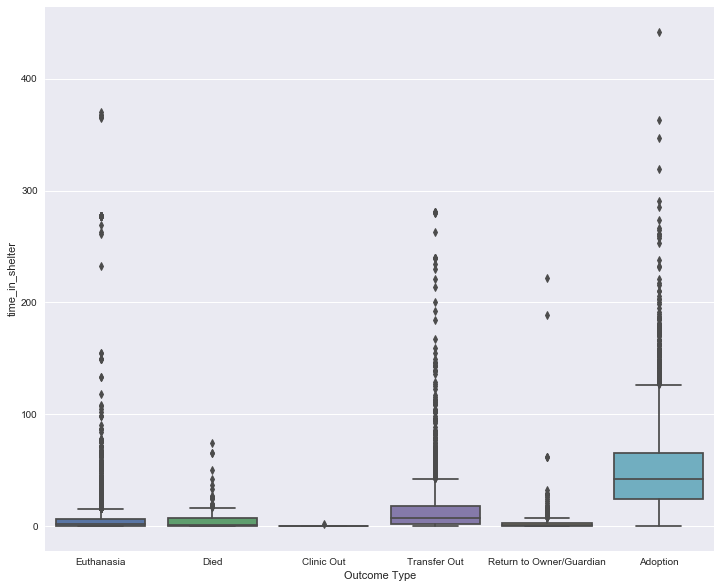

In [140]:
# for cats
time_in_shelter = full_dat[full_dat['time_in_shelter'] > pd.Timedelta(hours=0)]
time_in_shelter = time_in_shelter[time_in_shelter['Species'] == 'Cat']
time_in_shelter['time_in_shelter'] = time_in_shelter['time_in_shelter'].astype('timedelta64[D]')

import seaborn as sns
sns.boxplot(x='Outcome Type', y='time_in_shelter', data=time_in_shelter);

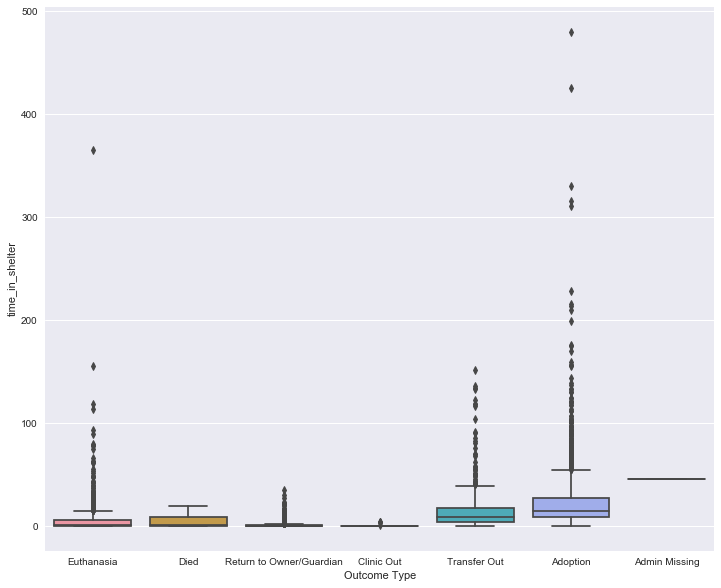

In [141]:
# for dogs
time_in_shelter = full_dat[full_dat['time_in_shelter'] > pd.Timedelta(hours=0)]
time_in_shelter = time_in_shelter[time_in_shelter['Species'] == 'Dog']
time_in_shelter['time_in_shelter'] = time_in_shelter['time_in_shelter'].astype('timedelta64[D]')

sns.boxplot(x='Outcome Type', y='time_in_shelter', data=time_in_shelter);

### Relationship between time and age

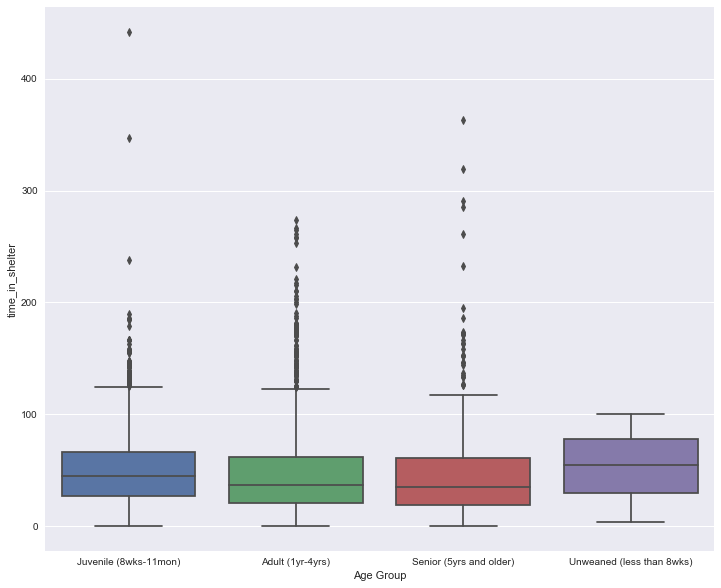

In [143]:
import seaborn as sns
# cats
time_in_shelter = full_dat[full_dat['time_in_shelter'] > pd.Timedelta(hours=0)]
time_in_shelter = time_in_shelter[time_in_shelter['Outcome Type'] == "Adoption"]

time_in_shelter = time_in_shelter[time_in_shelter['Species'] == 'Cat']
time_in_shelter['time_in_shelter'] = time_in_shelter['time_in_shelter'].astype('timedelta64[D]')

sns.boxplot(x='Age Group', y='time_in_shelter', data=time_in_shelter);

In [144]:
# perform kruskal wallis test for significant difference in distributions for adoption times
# removed unweaned since there weren't many
from scipy.stats import kruskal

adult = time_in_shelter['time_in_shelter'][time_in_shelter['Age Group'] == 'Adult (1yr-4yrs)']
senior = time_in_shelter['time_in_shelter'][time_in_shelter['Age Group'] == 'Senior (5yrs and older)']
juvenile = time_in_shelter['time_in_shelter'][time_in_shelter['Age Group'] == 'Juvenile (8wks-11mon)']

kruskal(adult, senior, juvenile)
#Post hoc comparisons between groups are required to determine which groups are different.

KruskalResult(statistic=44.04439411180208, pvalue=2.728232255597066e-10)

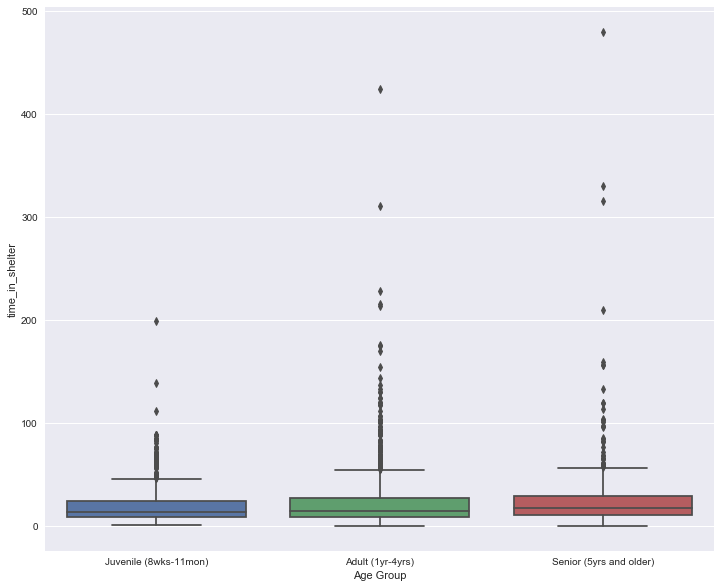

In [145]:
# dogs
time_in_shelter = full_dat[full_dat['time_in_shelter'] > pd.Timedelta(hours=0)]
time_in_shelter = time_in_shelter[time_in_shelter['Outcome Type'] == "Adoption"]

time_in_shelter = time_in_shelter[time_in_shelter['Species'] == 'Dog']
time_in_shelter['time_in_shelter'] = time_in_shelter['time_in_shelter'].astype('timedelta64[D]')

sns.boxplot(x='Age Group', y='time_in_shelter', data=time_in_shelter);

In [146]:
# perform kruskal wallis test for significant difference in distributions for adoption times

adult = time_in_shelter['time_in_shelter'][time_in_shelter['Age Group'] == 'Adult (1yr-4yrs)']
senior = time_in_shelter['time_in_shelter'][time_in_shelter['Age Group'] == 'Senior (5yrs and older)']
juvenile = time_in_shelter['time_in_shelter'][time_in_shelter['Age Group'] == 'Juvenile (8wks-11mon)']

kruskal(adult, senior, juvenile)
#Post hoc comparisons between groups are required to determine which groups are different.

KruskalResult(statistic=24.70349359315272, pvalue=4.32219666975104e-06)

In [147]:
# tested for difference between dogs and cats
time_in_shelter = full_dat[full_dat['time_in_shelter'] > pd.Timedelta(hours=0)]
time_in_shelter = time_in_shelter[time_in_shelter['Outcome Type'] == "Adoption"]


time_in_shelter['time_in_shelter'] = time_in_shelter['time_in_shelter'].astype('timedelta64[D]')

dogs = time_in_shelter['time_in_shelter'][time_in_shelter['Species'] == 'Dog']
cats = time_in_shelter['time_in_shelter'][time_in_shelter['Species'] == 'Cat']

kruskal(dogs, cats)

KruskalResult(statistic=1844.494555560235, pvalue=0.0)

In [148]:
#full_dat.to_csv("fcac_data_for_ml.csv")